# 4 Geocentric models

In [1]:
!pip install -q numpyro arviz causalgraphicalmodels daft

In [2]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

/Users/koenrademaker/miniconda3/envs/NUMPYRO/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 4.1.1 Normal by addition

In [3]:
# 4.1
pos = jnp.sum(dist.Uniform(-1, 1).sample(random.PRNGKey(0), (1000, 16)), -1)

I0000 00:00:1701880288.342730       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


array([[<Axes: >]], dtype=object)

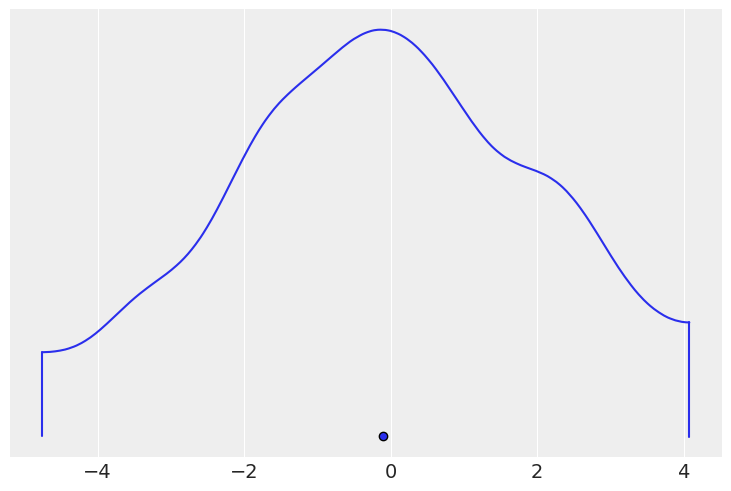

In [4]:
az.plot_density({"": pos})

### 4.1.2 Normal by multiplication

“Suppose the growth rate of an organism is influenced by a dozen loci, each with several alleles that code for more growth. Suppose also that all of these loci interact with one another, such that each increase growth by a percentage. This means that their effects multiply, rather than add.”

In [5]:
# 4.2
# Sample 12 random numbers between 0-0.1, multiply with 1 + these products.
jnp.prod(1 + dist.Uniform(0, 0.1).sample(random.PRNGKey(0), (12,)))

Array(1.7294353, dtype=float32)

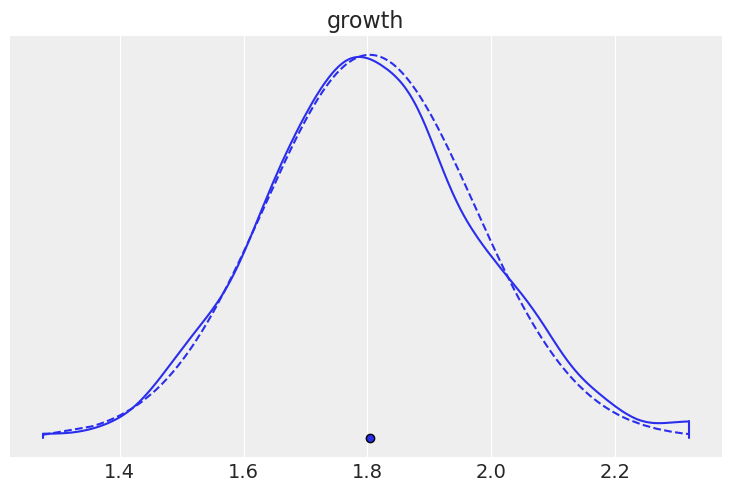

In [6]:
# 4.3
# Calculate distribution of such random products
growth = jnp.prod(1 + dist.Uniform(0, 0.1).sample(random.PRNGKey(0), (1000,12)),-1)
az.plot_density({"growth":growth}, hdi_prob=1)
x = jnp.sort(growth)
# Plot a Gaussian with the mean and std of growth values
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")
plt.show()

In this case of multiplication of small numbers, we get approximately the same as addition. The smaller the effect of each locus, the better the additive approximation will be. And as such, small effects that multiply together are approximately additive, and so they also tend to stabilize on Gaussian distributions.

In [7]:
# 4.4
big = growth = jnp.prod(1 + dist.Uniform(0, 0.5).sample(random.PRNGKey(0), (1000,12)),-1)
small = growth = jnp.prod(1 + dist.Uniform(0, 0.01).sample(random.PRNGKey(0), (1000,12)),-1)

array([[<Axes: title={'center': 'small'}>]], dtype=object)

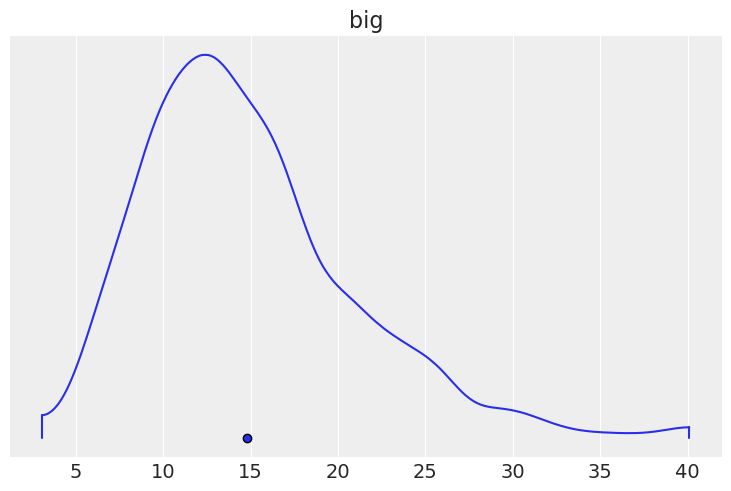

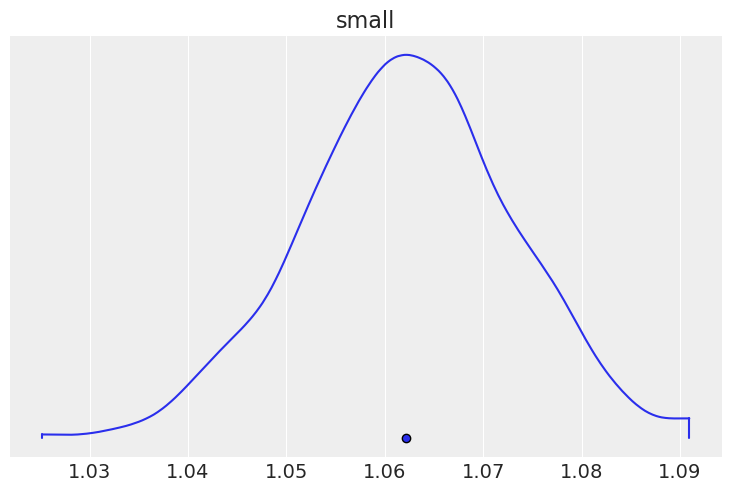

In [8]:
az.plot_density({"big":big}, hdi_prob=1)
az.plot_density({"small":small}, hdi_prob=1)

### 4.1.3 Normal by log-multiplication

array([[<Axes: title={'center': 'log_big'}>]], dtype=object)

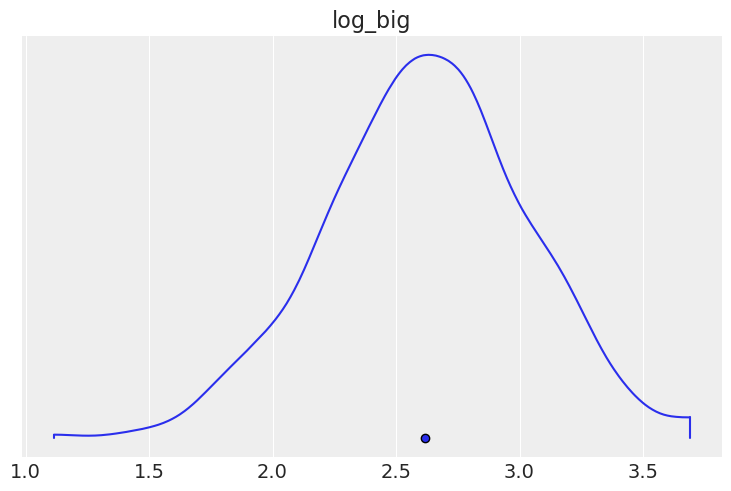

In [9]:
# 4.5
log_big = jnp.log(
    jnp.prod(1 + dist.Uniform(0, 0.5).sample(random.PRNGKey(0), (1000,12)),-1)
)
az.plot_density({"log_big":log_big}, hdi_prob=1)

### 4.1.4 Using Gaussians

$$p(y|\mu,\sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}exp\left(-\frac{{(y-\mu)}^2}{2\sigma^2}\right)$$

## 4.2 A language for describing models

$$ W \sim \text{Binomial}(N,p)$$
$$ p \sim \text{Uniform(0,1)}$$

W was the observed count of water, N was the total number of tosses, p was the proportion of water on the globe. The count W is distributed binomially with sample size N and probability p. The prior for p is assumed to be uniform between zero and one.

In [10]:
# 4.6
w = 6
n = 9
p_grid = jnp.linspace(start=0, stop=1, num=100)
prob_binom = jnp.exp(dist.Binomial(n, p_grid).log_prob(w))
posterior = prob_binom * jnp.exp(dist.Uniform(0,1).log_prob(p_grid))
posterior = posterior / jnp.sum(posterior)

array([[<Axes: title={'center': 'posterior'}>]], dtype=object)

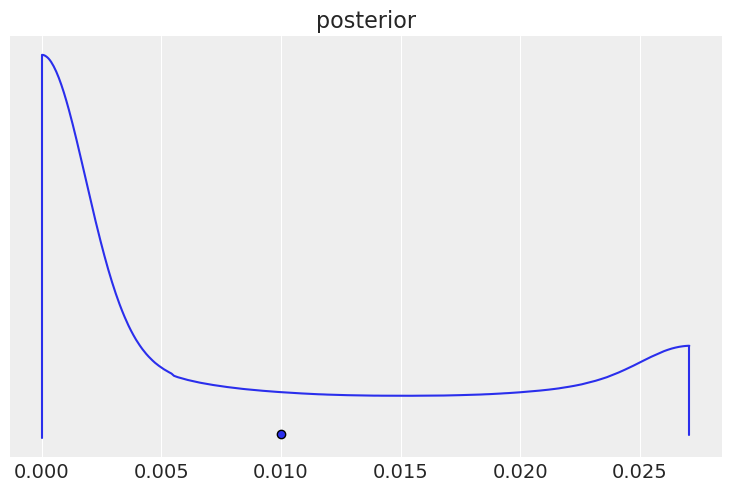

In [11]:
az.plot_density({"posterior":posterior})

## 4.3 Gaussian model of height

In [12]:
# 4.7
Howell = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell

In [13]:
# 4.8
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [14]:
# 4.9
print_summary(dict(zip(d.columns, d.T.values)), 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
       age     29.34     20.75     27.00      0.00     57.00    186.38      1.03
    height    138.26     27.60    148.59     90.81    170.18    218.68      1.06
      male      0.47      0.50      0.00      0.00      1.00    670.75      1.00
    weight     35.61     14.72     40.06     11.37     55.71    305.62      1.05



In [15]:
# 4.11
d2 = d[d.age >= 18]

In [16]:
d2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 352 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  352 non-null    float64
 1   weight  352 non-null    float64
 2   age     352 non-null    float64
 3   male    352 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 13.8 KB


### 4.3.2 The model

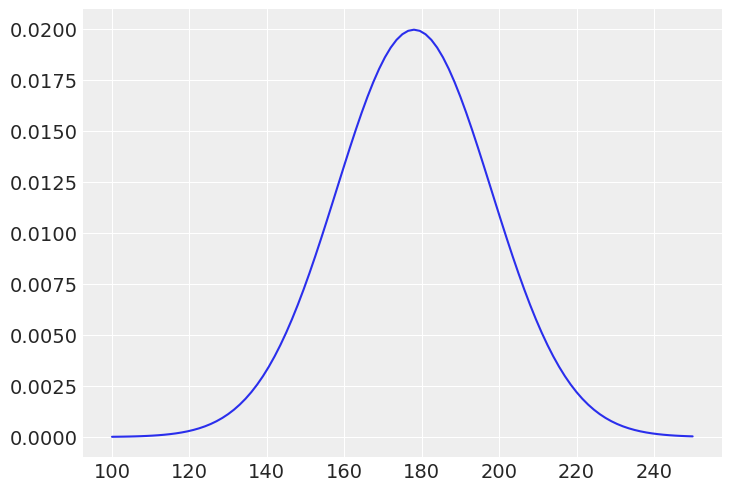

In [17]:
# 4.12
# Plot model priors
x = jnp.linspace(100,250,101)
plt.plot(x, jnp.exp(dist.Normal(178,20).log_prob(x)))
plt.show()

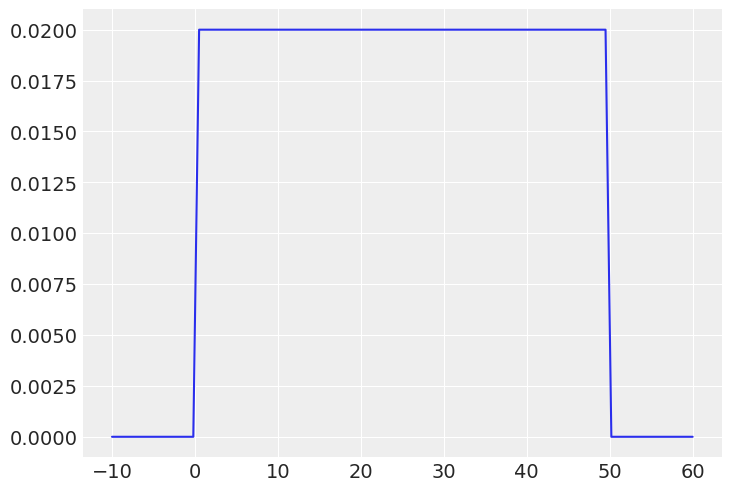

In [18]:
# 4.13
x = jnp.linspace(-10,60,101)
plt.plot(x, jnp.exp(dist.Uniform(0,50, validate_args=True).log_prob(x)))
plt.show()

**Prior predictive simulations**: Quickly simulate heights by sampling from the prior (like the posterior sampling in chapter 3).

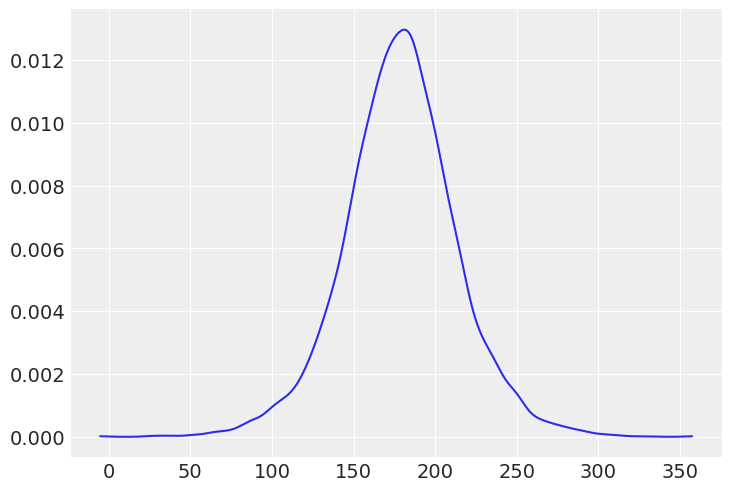

In [19]:
# 4.13
sample_mu = dist.Normal(178,20).sample(random.PRNGKey(0), (int(1e4),))
sample_sigma = dist.Uniform(0,50).sample(random.PRNGKey(1), (int(1e4),))
prior_h = dist.Normal(sample_mu, sample_sigma).sample(random.PRNGKey(2))
az.plot_kde(prior_h)
plt.show()

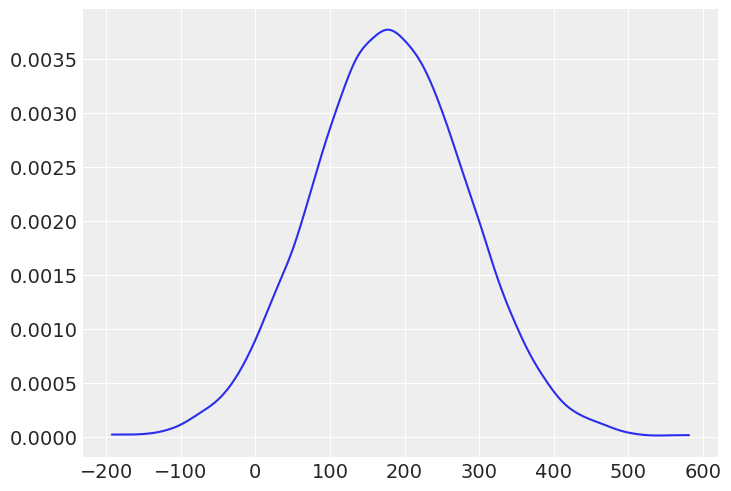

In [20]:
# 4.15
sample_mu = dist.Normal(178,100).sample(random.PRNGKey(0), (int(1e4),))
prior_h = dist.Normal(sample_mu, sample_sigma).sample(random.PRNGKey(2))
az.plot_kde(prior_h)
plt.show()

### 4.3.3 Grid approximation of posterior distribution

In [21]:
# 4.16
mu_list = jnp.linspace(start=150, stop=160, num=100)
sigma_list = jnp.linspace(start=7, stop=9, num=100)
mesh = jnp.meshgrid(mu_list, sigma_list)
post = {"mu": mesh[0].reshape(-1), "sigma": mesh[1].reshape(-1)}
post["LL"] = vmap(
    lambda mu, sigma: jnp.sum(dist.Normal(mu, sigma).log_prob(d2.height.values))
)(post["mu"], post["sigma"])
logprob_mu = dist.Normal(178, 20).log_prob(post["mu"])
logprob_sigma = dist.Uniform(0, 50).log_prob(post["sigma"])
post["prob"] = post["LL"] + logprob_mu + logprob_sigma
post["prob"] = jnp.exp(post["prob"] - jnp.max(post["prob"]))

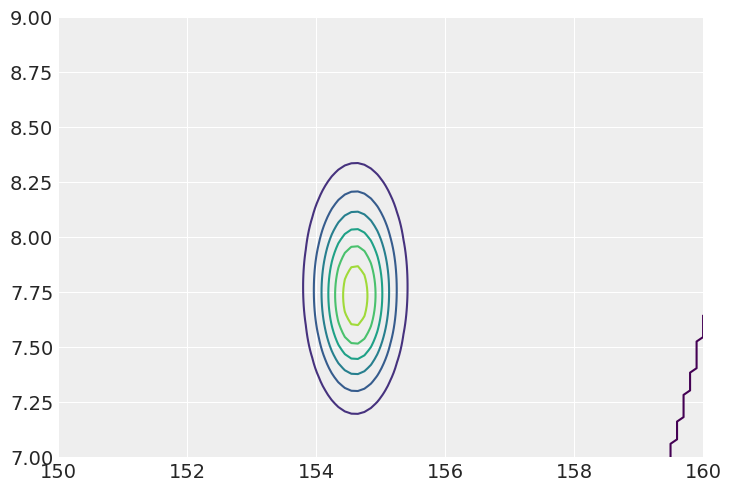

In [22]:
# 4.17
# Contour plot of posterior distribution samples for mu and sigma
plt.contour(
    post["mu"].reshape(100,100),
    post["sigma"].reshape(100,100),
    post["prob"].reshape(100,100)
)
plt.show()

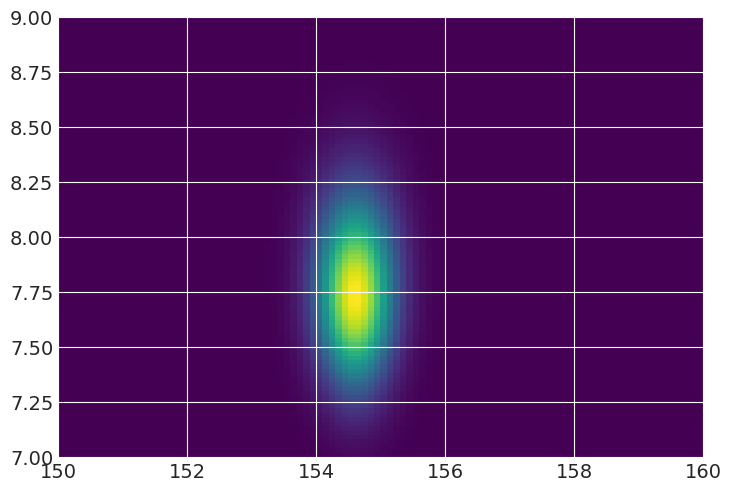

In [23]:
# 4.18
# Simple heatmap
plt.imshow(
    post["prob"].reshape(100,100),
    origin="lower",
    extent=(150,160,7,9),
    aspect="auto",
)
plt.show()

### 4.3.4 Sampling from the posterior

We will again sample values from the posterior distribution, however since there are now two parameters, we want to sample _combinations_ of parameters. In practice, randomly sample rows in proportion to the probability (`prob`) and extract parameter values.

In [24]:
# 4.19
prob = post["prob"] / jnp.sum(post["prob"])
sample_rows = dist.Categorical(probs=prob).sample(random.PRNGKey(0), (int(1e4),))
sample_mu = post["mu"][sample_rows]
sample_sigma = post["sigma"][sample_rows]

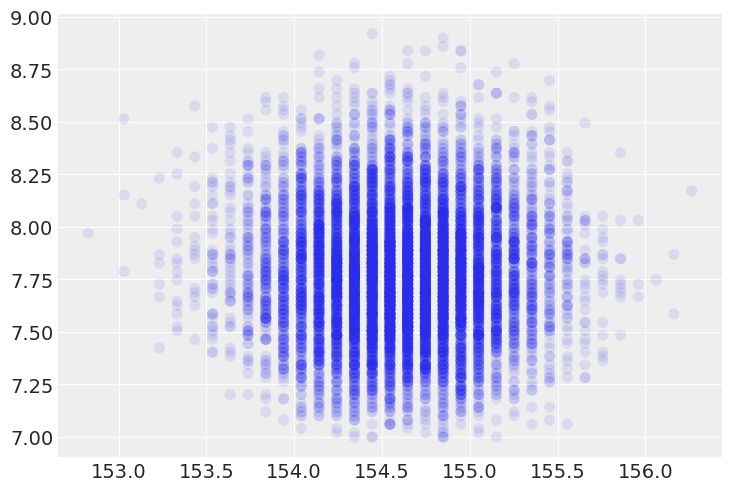

In [25]:
# 4.20
plt.scatter(sample_mu, sample_sigma, s=64, alpha=0.1, edgecolor="none")
plt.show()

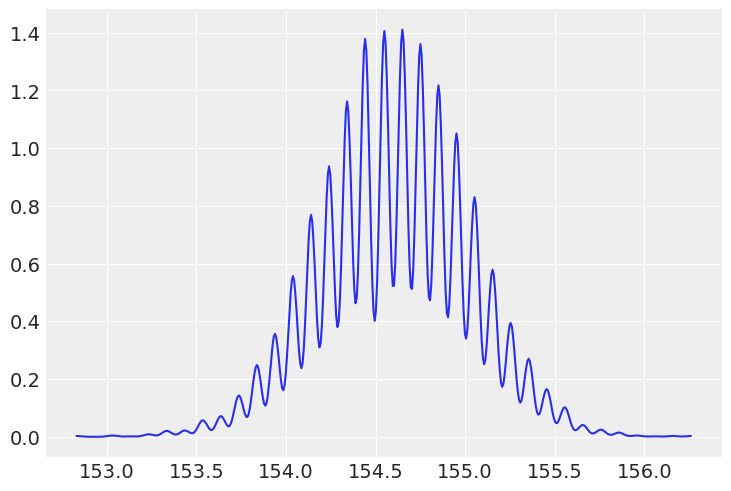

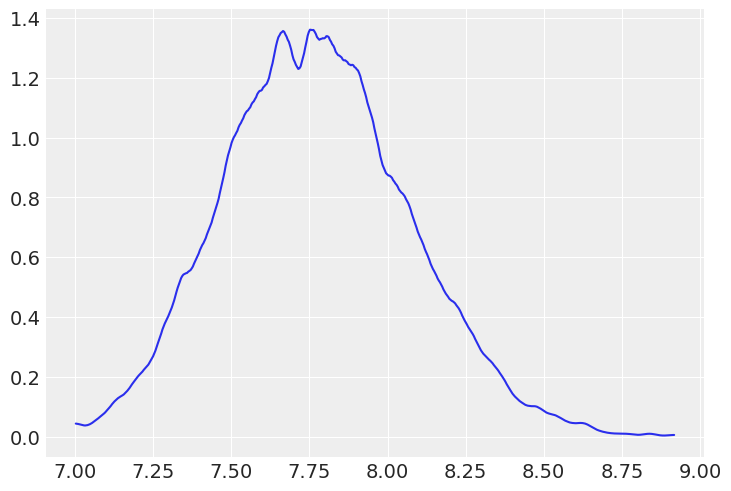

In [26]:
# 4.20
# Plot shapes of marginal posteriors densities of mu and sigma
az.plot_kde(sample_mu)
plt.show()
az.plot_kde(sample_sigma)
plt.show()

In [27]:
# 4.22
# Posterior compatibility intervals
print(hpdi(sample_mu, 0.89))
print(hpdi(sample_sigma, 0.89))

[153.93939 155.15152]
[7.3232327 8.252525 ]


In [28]:
# 4.23
# Overthinking: variance
d3 = d2.height.sample(n=20)

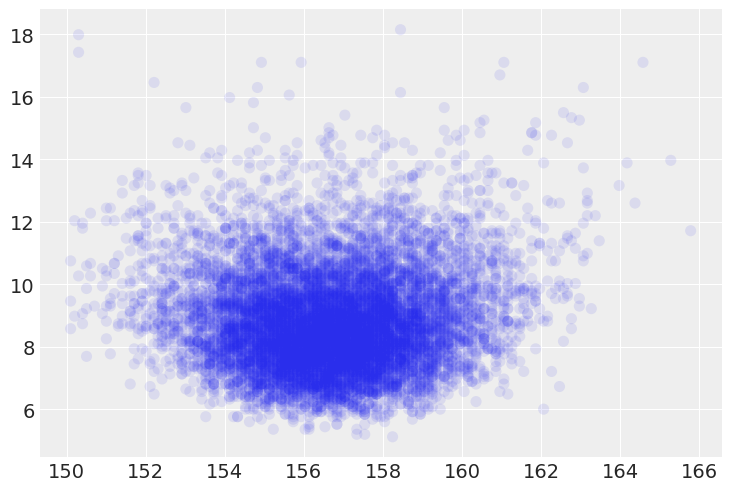

In [29]:
# 4.24
mu_list = jnp.linspace(start=150, stop=170, num=200)
sigma_list = jnp.linspace(start=4, stop=20, num=200)
mesh = jnp.meshgrid(mu_list, sigma_list)
post2 = {"mu": mesh[0].reshape(-1), "sigma": mesh[1].reshape(-1)}
post2["LL"] = vmap(
    lambda mu, sigma: jnp.sum(dist.Normal(mu, sigma).log_prob(d3.values))
)(post2["mu"], post2["sigma"])
logprob_mu = dist.Normal(178, 20).log_prob(post2["mu"])
logprob_sigma = dist.Uniform(0, 50).log_prob(post2["sigma"])
post2["prob"] = post2["LL"] + logprob_mu + logprob_sigma
post2["prob"] = jnp.exp(post2["prob"] - jnp.max(post2["prob"]))
prob = post2["prob"] / jnp.sum(post2["prob"])
sample2_rows = dist.Categorical(probs=prob).sample(random.PRNGKey(0), (int(1e4),))
sample2_mu = post2["mu"][sample2_rows]
sample2_sigma = post2["sigma"][sample2_rows]
plt.scatter(sample2_mu, sample2_sigma, s=64, alpha=0.1, edgecolor="none")
plt.show()

This scatter plot shows samples from the posterior density, but this time with a longer tail at the top (higher sigma values).

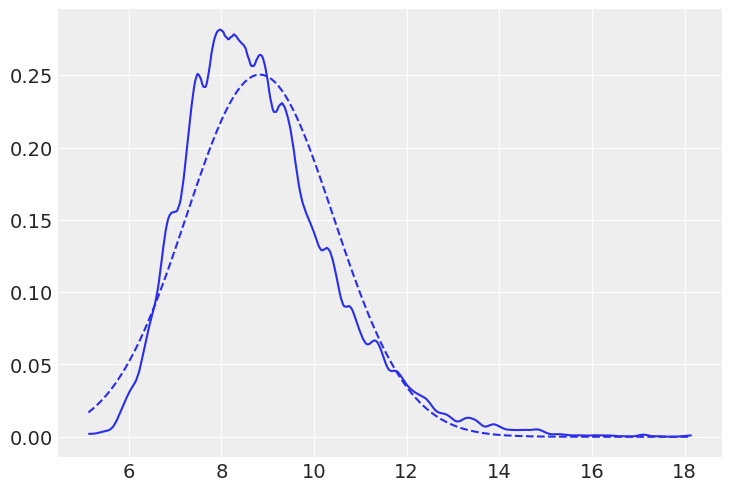

In [30]:
# 4.25
# Marginal posterior density for sigma, averaging over mu
az.plot_kde(sample2_sigma)
x = jnp.sort(sample2_sigma)
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")
plt.show()

Inspecting the marginal posterior density for $\sigma$, averaging over $\mu$, shows a normal approximation with identical mean and variance. Now, we can see that the posterior for $\sigma$ is not Gaussian, but instead has a longer tail of uncertainty towards higher values.

### 4.3.5 Finding the posterior distribution with quadratic approximation

The posterior’s peak will lie at the maximum a posteriori estimate (MAP), and we can get a useful image of the posterior’s shape by using the quadratic approximation of the posterior distribution at this peak.

The quap (R name) function works by using the model definition you were introduced to earlier in this chapter. Each line in the definition has a corresponding definition in the form of R code. The engine inside quap then uses these definitions to define the posterior probability at each combination of parameter values. Then it can climb the posterior distribution and find the peak, its MAP. Finally, it estimates the quadratic curvature at the MAP to produce an approximation of the posterior distribution. Remember: This procedure is very similar to what many non-Bayesian procedures do, just without any priors

In [31]:
# 4.26
Howell = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell
d2 = d[d['age'] >= 18]

In [32]:
# 4.27
# Define a formula list (flist)
def flist(height):
    mu = numpyro.sample('mu', dist.Normal(178,20))
    sigma = numpyro.sample('sigma', dist.Uniform(0,50))
    numpyro.sample("height", dist.Normal(mu,sigma), obs=height)

In [33]:
# 4.28
# Fit model to the data in the dataframe d2
m4_1 = AutoLaplaceApproximation(flist)
svi = SVI(flist,
          m4_1,
          optim.Adam(1),
          Trace_ELBO(),
          height=d2.height.values)
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_1 = svi_result.params

100%|█| 2000/2000 [00:00<00:00, 9947.38it/s, init loss: 4000.1150, avg. loss [19


In [34]:
# 4.29
# Inspect the posterior distribution, i.e. Gaussian approximations for each paramter's marginal distribution
samples = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (1000,))
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.60      0.40    154.60    154.00    155.28    995.05      1.00
     sigma      7.76      0.30      7.76      7.33      8.26   1007.15      1.00



In [35]:
# 4.30
# Quadratic approximation of posterior WITH start values
start = {"mu": d2.height.mean(), "sigma": d2.height.std()}
m4_1 = AutoLaplaceApproximation(flist, init_loc_fn=init_to_value(values=start))
svi = SVI(flist, m4_1, optim.Adam(0.1), Trace_ELBO(), height=d2.height.values)
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_1 = svi_result.params

100%|█| 2000/2000 [00:00<00:00, 10420.53it/s, init loss: 1226.0387, avg. loss [1


In [36]:
# 4.31
# Introduce new model with more narrow prior on std of Normal for mu
def model(height):
    mu = numpyro.sample("mu", dist.Normal(178, 0.1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m4_2, optim.Adam(1), Trace_ELBO(), height=d2.height.values)
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_2 = svi_result.params
samples = m4_2.sample_posterior(random.PRNGKey(1), p4_2, (1000,))
print_summary(samples, 0.89, False)

100%|█| 2000/2000 [00:00<00:00, 10791.64it/s, init loss: 1584193.6250, avg. loss



                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    177.86      0.10    177.86    177.72    178.03    995.05      1.00
     sigma     24.57      0.94     24.60     23.01     25.96   1012.88      1.00



“Notice that the estimate for μ has hardly moved off the prior. The prior was very concentrated around 178. So this is not surprising. But also notice that the estimate for σ has changed quite a lot, even though we didn’t change its prior at all. Once the golem is certain that the mean is near 178—as the prior insists—then the golem has to estimate σ conditional on that fact. This results in a different posterior for σ, even though all we changed is prior information about the other parameter”

### 4.3.6 Sampling from a quadratic approximation

The key thing to understand is that - in order to be able to get samples from a posterior distribution obtained from the quadratic approximation - when there is more than one parameter dimension - here $\mu$ and $\sigma$ - the posterior is in fact just a multi-dimensional Gaussian.

Hence, not only standard deviations for all parameters are calculated, but also the **covariance** among pairs of parameters. Together, the list of means and matrix of variances and covariances are sufficient to describe a multi-dimensional Gaussian.

In [37]:
# 4.32
samples = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (1000,))
vcov = jnp.cov(jnp.stack(list(samples.values()), axis = 0))
vcov

Array([[0.16249587, 0.00154646],
       [0.00154646, 0.08733496]], dtype=float32)

In [38]:
# 4.33
# Diagonal (variances)
print(jnp.diagonal(vcov))
# Correlation matrix
print(vcov / jnp.sqrt(jnp.outer(jnp.diagonal(vcov), jnp.diagonal(vcov))))

[0.16249587 0.08733496]
[[1.         0.01298147]
 [0.01298147 1.        ]]


“The two-element vector in the output is the list of variances. If you take the square root of this vector, you get the standard deviations that are shown in precis output. The two-by-two matrix in the output is the correlation matrix. Each entry shows the correlation, bounded between −1and +1, for each pair of parameters. The 1’s indicate a parameter’s correlation with itself. If these values were anything except 1, we would be worried. The other entries are typically closer to zero, and they are very close to zero in this example. This indicates that learning μ tells us nothing about σ and likewise that learning σ tells us nothing about μ.” 

Instead of sapling single values from a simpel Gaussian, we now sample vectors of values from a multi-dimensional Gaussian.

In [39]:
# 4.34
post = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (int(1e4),))
{latent: list(post[latent][:6]) for latent in post}

{'mu': [Array(154.2356, dtype=float32),
  Array(154.47672, dtype=float32),
  Array(154.97047, dtype=float32),
  Array(154.20374, dtype=float32),
  Array(155.48271, dtype=float32),
  Array(154.81831, dtype=float32)],
 'sigma': [Array(7.5602665, dtype=float32),
  Array(7.306454, dtype=float32),
  Array(7.27963, dtype=float32),
  Array(7.8118353, dtype=float32),
  Array(7.9042172, dtype=float32),
  Array(7.978001, dtype=float32)]}

In [40]:
# 4.35
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.60      0.41    154.60    153.93    155.24   9926.99      1.00
     sigma      7.75      0.29      7.74      7.29      8.23   9502.45      1.00



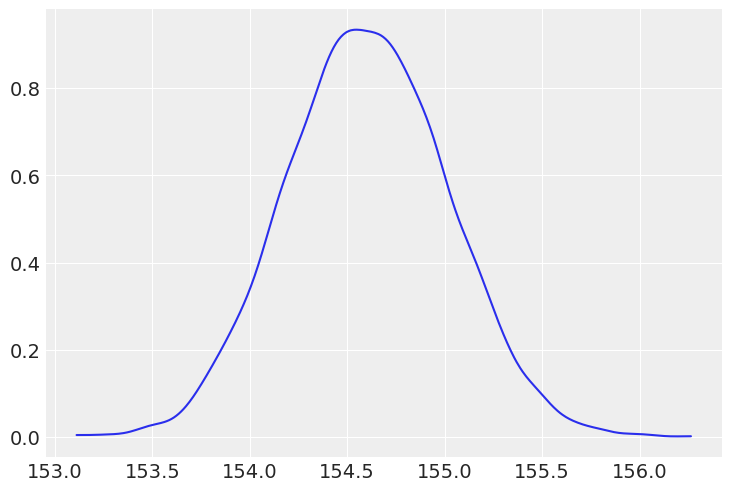

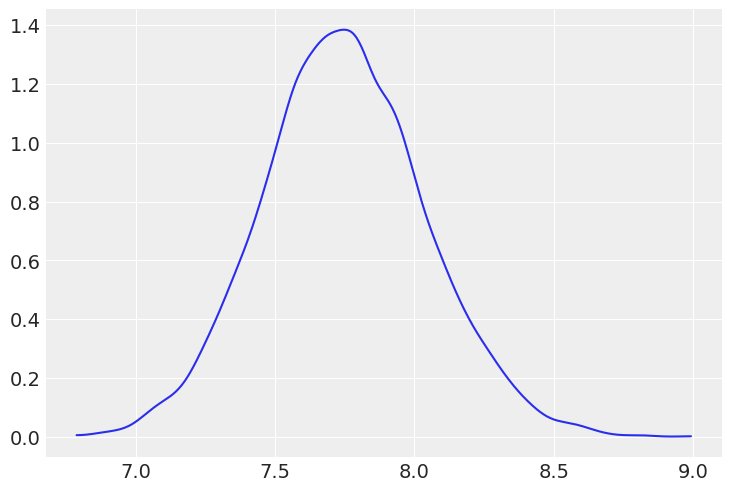

In [41]:
# Plot shapes of marginal posteriors densities of mu and sigma
az.plot_kde(post['mu'])
plt.show()
az.plot_kde(post['sigma'])
plt.show()

In [42]:
# 4.36
# Multivariate sampling
samples_flat = jnp.stack(list(post.values()))
mu, sigma = jnp.mean(samples_flat, axis=1), jnp.cov(samples_flat)
post = dist.MultivariateNormal(mu,sigma).sample(random.PRNGKey(0), (int(1e4),))

## 4.4 Linear prediction

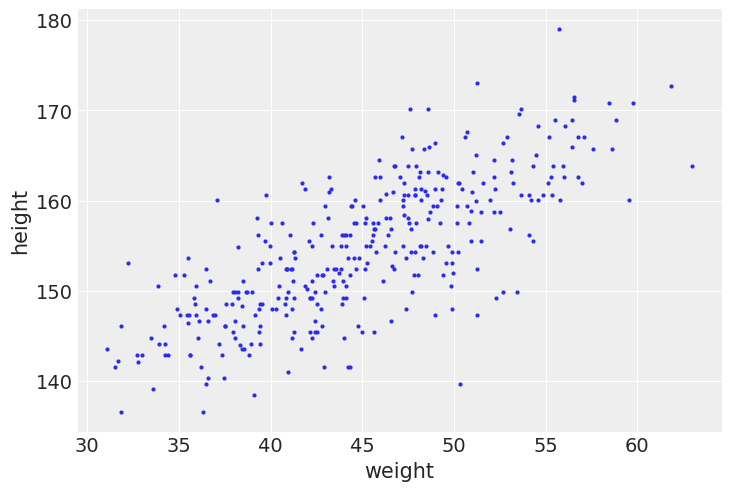

In [43]:
# 4.37
az.plot_pair(d2[['weight','height']].to_dict(orient='list'))
plt.show()

### 4.4.1 Linear model

We will first model height from weight, adapting the previous Gaussian model to weight the influence of weight (*badum-tss*):

$$h_i \sim \text{Normal}(u_i, σ)$$ [likelihood]

$$μ_i = α + β(x_i − \bar{x})$$ [linear model]

$$α \sim \text{Normal}(178, 20)$$ [α prior]

$$β \sim \text{Normal}(0, 10)$$ [β prior]

$$σ \sim \text{Uniform}(0, 50)$$ [σ prior]

In [44]:
# 4.38
# Simulations of alpha and beta values
with numpyro.handlers.seed(rng_seed=2971):
    N = 100
    a = numpyro.sample('a', dist.Normal(178,20).expand([N]))
    b = numpyro.sample('b', dist.Normal(0,10).expand([N]))

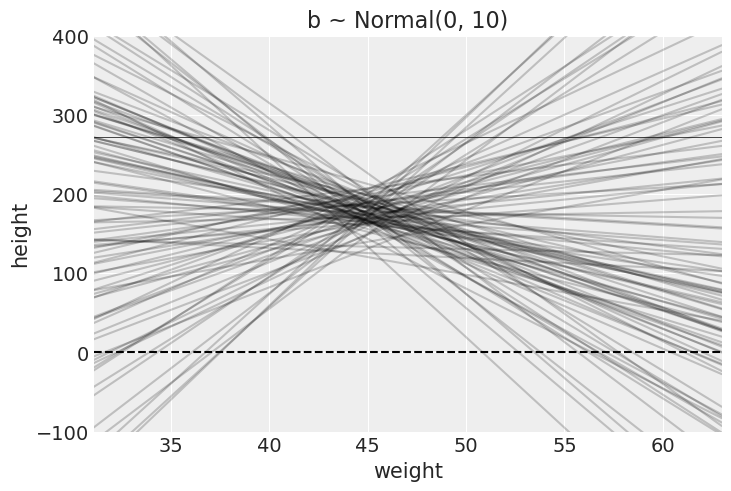

In [45]:
# 4.39
# Plot lines for simulated alpha and beta values
plt.subplot(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(-100,400),
    ylabel='height',
    xlabel='weight',)
plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=272, c="k", ls="-", lw=0.5)
plt.title("b ~ Normal(0, 10)")
xbar = d2.weight.mean()
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2)
plt.show()

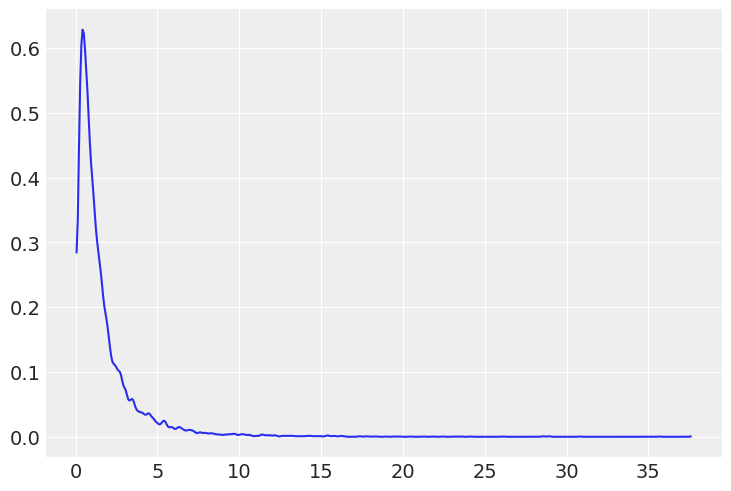

In [46]:
# 4.40
# Switch beta to Log-Normal instead to enforce positive relationships
b = dist.LogNormal(0, 1).sample(random.PRNGKey(0), (int(1e4),))
az.plot_kde(b)
plt.show()

In [47]:
# 4.41
with numpyro.handlers.seed(rng_seed=2971):
    N = 100
    a = numpyro.sample('a', dist.Normal(178,20).expand([N]))
    b = numpyro.sample('b', dist.LogNormal(0,1).expand([N]))

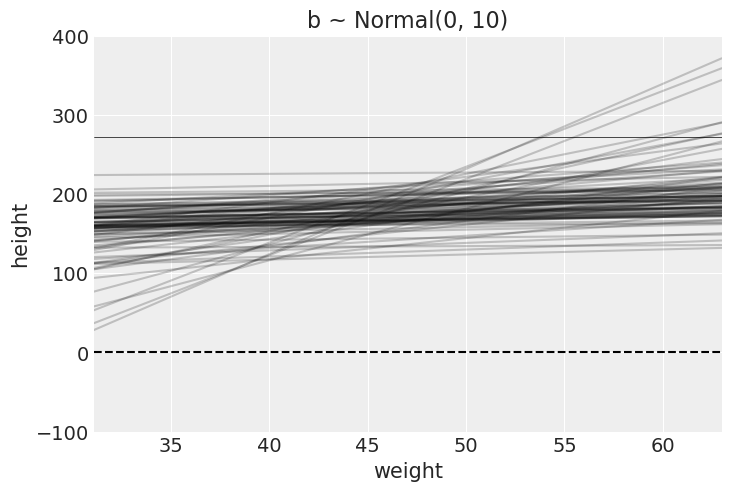

In [48]:
plt.subplot(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(-100,400),
    ylabel='height',
    xlabel='weight',)
plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=272, c="k", ls="-", lw=0.5)
plt.title("b ~ Normal(0, 10)")
xbar = d2.weight.mean()
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2)
plt.show()

### 4.4.2 Finding the posterior distribution

In [49]:
# 4.42
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1
d2 = d[d["age"] >= 18]

# define the average weight, x-bar
xbar = d2.weight.mean()


# fit model
def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * (weight - xbar))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_3 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m4_3,
    optim.Adam(1),
    Trace_ELBO(),
    weight=d2.weight.values,
    height=d2.height.values,
)
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_3 = svi_result.params

100%|█| 2000/2000 [00:00<00:00, 9211.45it/s, init loss: 40631.5430, avg. loss [1


### 4.4.3 Interpreting the posterior distribution

In [50]:
# 4.44
# Marginal posterior distributions of the parameters
samples = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
samples.pop('mu')
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a    154.62      0.27    154.63    154.16    155.03    931.50      1.00
         b      0.91      0.04      0.90      0.84      0.97   1083.74      1.00
     sigma      5.08      0.19      5.08      4.79      5.41    949.65      1.00



Remember that these outputs are not sufficient to describe to quadratic approximation of the posterior completely. For that, we need the variance-covariance matrix.

In [51]:
# 4.45
vcov = jnp.cov(jnp.stack(list(samples.values()), axis=0))
jnp.round(vcov,3)

Array([[ 0.075, -0.   ,  0.001],
       [-0.   ,  0.002, -0.   ],
       [ 0.001, -0.   ,  0.038]], dtype=float32)

In [52]:
# Diagonal (variances)
print(jnp.diagonal(vcov))


[0.07512339 0.00182094 0.03782354]


Very little covariation among parameters here.

In [53]:
# Correlation matrix
print(vcov / jnp.sqrt(jnp.outer(jnp.diagonal(vcov), jnp.diagonal(vcov))))

[[ 1.         -0.00852417  0.02380831]
 [-0.00852417  1.         -0.00916402]
 [ 0.02380831 -0.00916402  1.        ]]


#### 4.4.3.2. Plotting posterior inference against the data.

"It’s almost always much more useful to plot the posterior inference against the data. Not only does plotting help in interpreting the posterior, but it also provides an informal check on model assumptions. When the model’s predictions don’t come close to key observations or patterns in the plotted data, then you might suspect the model either did not fit correctly or is rather badly specified. But even if you only treat plots as a way to help in interpreting the posterior, they are invaluable."

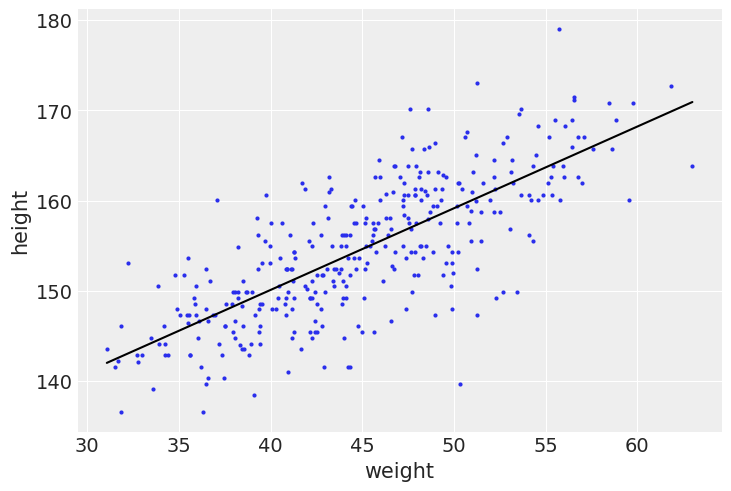

In [54]:
# 4.46
# Superimposing posterior mean values over weight and height values
az.plot_pair(d2[['weight', 'height']].to_dict(orient='list'))
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
a_map = jnp.mean(post['a'])
b_map = jnp.mean(post['b'])
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
plt.plot(x, a_map + b_map * (x - xbar), 'k')
plt.show()

#### 4.4.3.3 Adding uncertainty around the mean

In [55]:
# 4.47
# Sample five random samples from the posterior 
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
{latent: list(post[latent].reshape(-1)[:5]) for latent in post}

{'a': [Array(154.36615, dtype=float32),
  Array(154.78511, dtype=float32),
  Array(154.73534, dtype=float32),
  Array(154.53842, dtype=float32),
  Array(154.53549, dtype=float32)],
 'b': [Array(0.97464514, dtype=float32),
  Array(0.89000493, dtype=float32),
  Array(0.8190222, dtype=float32),
  Array(0.8334105, dtype=float32),
  Array(1.0119181, dtype=float32)],
 'mu': [Array(157.12938, dtype=float32),
  Array(146.0771, dtype=float32),
  Array(141.5733, dtype=float32),
  Array(162.21344, dtype=float32),
  Array(150.74669, dtype=float32)],
 'sigma': [Array(4.9764595, dtype=float32),
  Array(4.94353, dtype=float32),
  Array(5.2826037, dtype=float32),
  Array(4.877722, dtype=float32),
  Array(4.89487, dtype=float32)]}

In [56]:
# 4.48
# Extract N samples and re-estimate the model

N = 10
dN = d2[:N]

def model(weight, height):
    a = numpyro.sample('a', dist.Normal(178,20))
    b = numpyro.sample('b', dist.LogNormal(0,1))
    sigma = numpyro.sample('sigma', dist.Uniform(0,50))
    mu = a + b * (weight - jnp.mean(weight))
    numpyro.sample('height', dist.Normal(mu, sigma), obs = height)

mN = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    mN,
    optim.Adam(1),
    Trace_ELBO(),
    weight = dN.weight.values,
    height = dN.height.values
)

svi_result = svi.run(random.PRNGKey(0), 1000)
pN = svi_result.params

100%|█| 1000/1000 [00:00<00:00, 6121.60it/s, init loss: 1233.4980, avg. loss [95


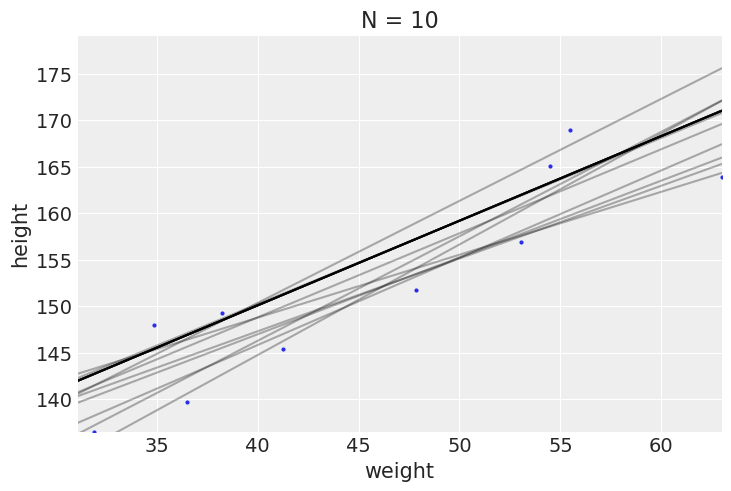

In [57]:
# extract 20 samples from the posterior
post = mN.sample_posterior(random.PRNGKey(1), pN, (N,))

# display raw data and sample size
ax = az.plot_pair(dN[["weight", "height"]].to_dict(orient="list"))
ax.set(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(d2.height.min(), d2.height.max()),
    title="N = {}".format(N),
)

# plot the lines, with transparency
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(20):
    plt.plot(x, post["a"][i] + post["b"][i] * (x - dN.weight.mean()), "k", alpha=0.3)


#### 4.4.3.4 Plotting regression contours and intervals

In [58]:
# 4.50
# Sample 1000 values for an individual with weight = 50kg
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
mu_at_50 = post['a'] + post['b'] * (50 - xbar)

“Since joint a and b went into computing each, the variation across those means incorporates the uncertainty in and correlation between both parameters. It might be helpful at this point to actually plot the density for this vector of means”

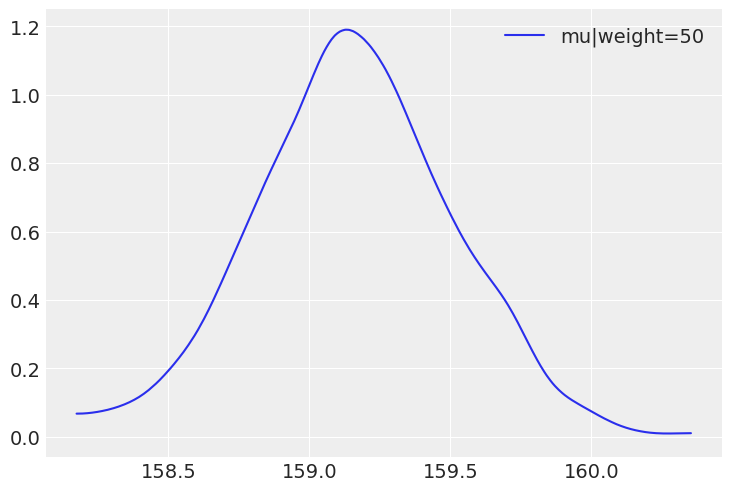

In [59]:
# 4.51
az.plot_kde(mu_at_50, label='mu|weight=50')
plt.show()

In [60]:
# 4.52
# Find 89% compatability interval for mu at 50kg from HDPI
jnp.percentile(mu_at_50, q=jnp.array([5.5, 94.5]))

Array([158.5957 , 159.71445], dtype=float32)

In [61]:
# 4.53
# Draw 89% intervals around the previously calculated average slope
mu = Predictive(m4_3.model,
                post,
                return_sites=['mu'])(random.PRNGKey(2),
                                     d2.weight.values,
                                     d2.height.values)['mu']
mu.shape, list(mu[:5, 0])

((1000, 352),
 [Array(157.12938, dtype=float32),
  Array(157.30838, dtype=float32),
  Array(157.05736, dtype=float32),
  Array(156.90125, dtype=float32),
  Array(157.4044, dtype=float32)])

We just calculated a distribution on μ for each individual in the data.

Next, we want a distribution of μ for each unique weight value on the horizontal axis.

In [62]:
# 4.54

# Define sequence of weights to compute predictions for, and place on the horiz. axis
weight_seq = jnp.arange(start=25, stop=71, step=1)

# Use Predictive() to compute mu for each sample from posterior and for each weight in weight_seq
mu = Predictive(m4_3.model, post, return_sites=["mu"])(
    random.PRNGKey(2), weight_seq, None
)["mu"]
mu.shape, list(mu[:5, 0])

((1000, 46),
 [Array(134.88252, dtype=float32),
  Array(136.99348, dtype=float32),
  Array(138.36269, dtype=float32),
  Array(137.87814, dtype=float32),
  Array(134.30676, dtype=float32)])

Now we have 1000 samples from the posterior predictive distribution, with 46 columns corresponding to the 46 different values for `weight` that we fed it.

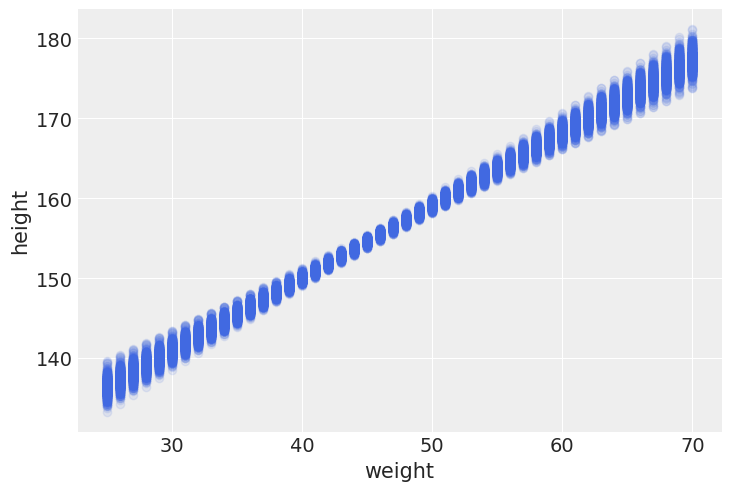

In [63]:
# 4.55
az.plot_pair(
    d2[['weight','height']].to_dict(orient='list'), scatter_kwargs={'alpha': 0}
)

for i in range(1000):
    plt.plot(weight_seq,
             mu[i],
             'o',
             c='royalblue',
             alpha=0.1)

At each weight value in weight.seq, a pile of computed μ values are shown. Each of these piles is a Gaussian distribution.

In [64]:
# 4.56
# Summarise the distribution of mu for each value of weight
mu_mean = jnp.mean(mu,0) # 0 indicates calculating mean over columns
mu_PI = jnp.percentile(mu, q = jnp.array([5.5,94.5]), axis=0)

In [65]:
print(mu_mean)
print(mu_PI)

[136.51378 137.4195  138.3252  139.23091 140.13663 141.04233 141.94804
 142.85379 143.75946 144.66519 145.5709  146.47665 147.38234 148.28807
 149.19376 150.0995  151.0052  151.91093 152.81664 153.72235 154.62807
 155.5338  156.43948 157.34523 158.25095 159.15663 160.06235 160.96806
 161.87378 162.77951 163.68521 164.59094 165.49666 166.40233 167.30807
 168.21379 169.11949 170.02522 170.93095 171.83665 172.7424  173.64809
 174.55377 175.4595  176.36523 177.27094]
[[135.08698 136.04176 137.00163 137.97308 138.94916 139.91855 140.87654
  141.84944 142.8079  143.78815 144.757   145.7285  146.68051 147.62679
  148.57896 149.52205 150.47641 151.41951 152.3567  153.26152 154.18149
  155.07791 155.96138 156.85262 157.72363 158.5957  159.45923 160.33806
  161.19484 162.05424 162.92712 163.77315 164.6199  165.46143 166.305
  167.14659 168.00763 168.86089 169.69896 170.55197 171.39201 172.22789
  173.07329 173.91154 174.75435 175.60542]
 [137.8982  138.73918 139.58368 140.42934 141.26926 142.111

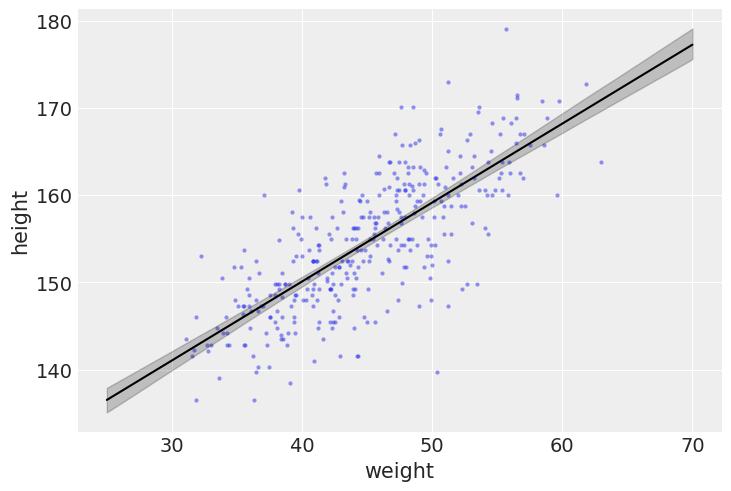

In [66]:
# 4.57
az.plot_pair(
    d2[['weight','height']].to_dict(orient='list'), scatter_kwargs={"alpha": 0.5}
)

# MAP
plt.plot(weight_seq, mu_mean, 'k')

# 89% PI
plt.fill_between(weight_seq,
                 mu_PI[0],
                 mu_PI[1],
                 color='k',
                 alpha=0.2)
plt.show()

"Even a very bad model can have very tight confidence intervals. It may help if you think of the regression line in Figure 4.9 as saying: Conditional on the assumption that height and weight are related by a straight line, then this is the most plausible line, and these are its plausible bounds."

To summarize, here’s the recipe for generating predictions and intervals from the posterior of a fit model.

- (1) Use `Predictive` to generate distributions of posterior values for μ. The default behavior of `Predictive` is to use the original data, so you have to pass it a list of new horizontal axis values you want to plot posterior predictions across.
- (2) Use summary functions like mean or PI to find averages and lower and upper bounds of μ for each value of the predictor variable.
- (3) Finally, use plotting functions like lines and shade to draw the lines and intervals. Or you might plot the distributions of the predictions, or do further numerical calculations with them. It’s really up to you.

**Overthinking: How link works.**

"The function link (R name) is not really very sophisticated. All it is doing is using the formula you provided when you fit the model to compute the value of the linear model. It does this for each sample from the posterior distribution, for each case in the data. You could accomplish the same thing for any model, fit by any means, by performing these steps yourself. This is how it’d look for m4_3:

(...)

And the values in mu.mean and mu.CI should be very similar (allowing for simulation variance) to what you got the automated way, using link. Knowing this manual method is useful both for (1) understanding and (2) sheer power. Whatever the model you find yourself with, this approach can be used to generate posterior predictions for any component of it. Automated tools like link save effort, but they are never as flexible as the code you can write yourself."

In [67]:
# 4.58
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
mu_link = lambda weight: post['a'] + post['b'] * (weight - xbar)
weight_seq = jnp.arange(start=25,stop=71,step=1)
mu = vmap(mu_link)(weight_seq).T
mu_mean = jnp.mean(mu,0)
mu_HPDI = hpdi(mu, prob=0.89, axis=0)

In [68]:
print(mu)
print(mu_mean)
print(mu_HPDI)

[[134.88252 135.85716 136.83182 ... 176.79227 177.7669  178.74155]
 [136.99348 137.88348 138.77348 ... 175.26369 176.1537  177.0437 ]
 [138.36269 139.1817  140.00073 ... 173.58064 174.39966 175.21869]
 ...
 [137.7004  138.53241 139.36443 ... 173.47728 174.3093  175.14131]
 [135.7536  136.67506 137.59651 ... 175.37619 176.29765 177.2191 ]
 [136.57593 137.47998 138.38403 ... 175.45052 176.35458 177.25864]]
[136.51378 137.4195  138.3252  139.23091 140.13663 141.04233 141.94804
 142.85379 143.75946 144.66519 145.5709  146.47665 147.38234 148.28807
 149.19376 150.0995  151.0052  151.91093 152.81664 153.72235 154.62807
 155.5338  156.43948 157.34523 158.25095 159.15663 160.06235 160.96806
 161.87378 162.77951 163.68521 164.59094 165.49666 166.40233 167.30807
 168.21379 169.11949 170.02522 170.93095 171.83665 172.7424  173.64809
 174.55377 175.4595  176.36523 177.27094]
[[135.12962 136.10736 137.0686  138.04832 139.02922 139.99277 140.92696
  141.9427  142.89584 143.78937 144.74571 145.7287  

#### 4.4.3.5 Prediction intervals

What we do next is, _for each weight_, sampling from a Gaussian with correct mean μ and correct value of σ sampled from the same posterior , such that you simulate heights embodying the uncertainty in both posterior and Gaussian dist. of height for each weight value of interest.

In [69]:
# 4.59
sim_height = Predictive(m4_3.model, post, return_sites=["height"])(
    random.PRNGKey(2), weight_seq, None
)["height"]
sim_height.shape, list(sim_height[:5, 0])

((1000, 46),
 [Array(135.85771, dtype=float32),
  Array(137.52162, dtype=float32),
  Array(133.89777, dtype=float32),
  Array(138.14607, dtype=float32),
  Array(131.1664, dtype=float32)])

In [70]:
# 4.60
# Summarize simulated heights
height_PI = jnp.percentile(sim_height, q=jnp.array([5.5, 94.5]), axis=0)

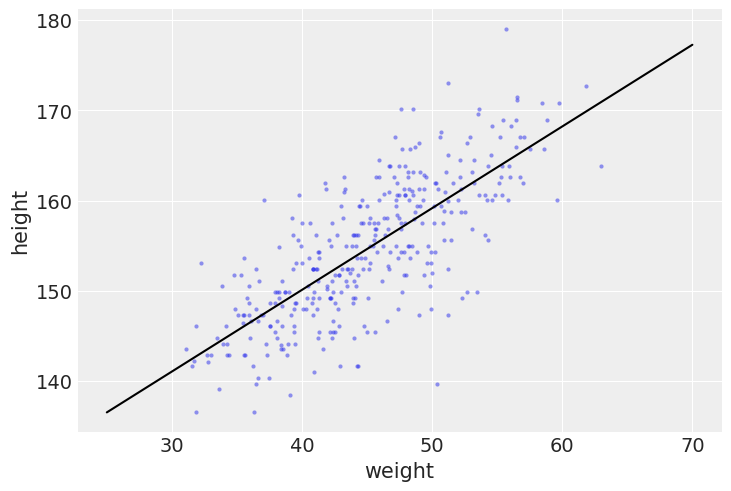

In [71]:
# 4.61
# plot raw data
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)
# draw MAP line
plt.plot(weight_seq, mu_mean, "k")

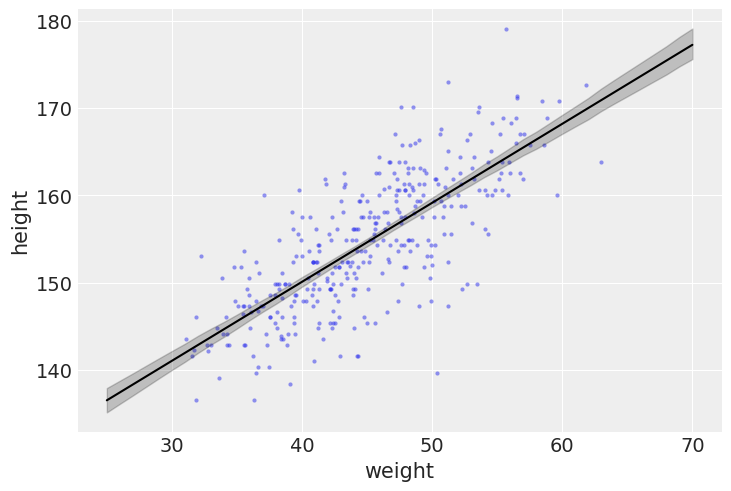

In [72]:
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)
# draw MAP line
plt.plot(weight_seq, mu_mean, "k")
# draw HPDI region for line
plt.fill_between(weight_seq, mu_HPDI[0], mu_HPDI[1], color="k", alpha=0.2)

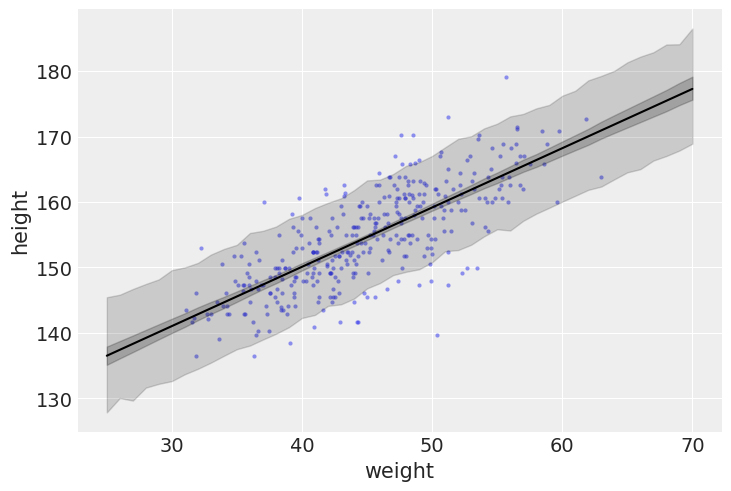

In [73]:
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)
# draw MAP line
plt.plot(weight_seq, mu_mean, "k")
# draw HPDI region for line
plt.fill_between(weight_seq, mu_HPDI[0], mu_HPDI[1], color="k", alpha=0.2)
# draw PI region for simulated heights
plt.fill_between(weight_seq, height_PI[0], height_PI[1], color="k", alpha=0.15)
plt.show()

In [74]:
# 4.62
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (10000,))
sim_height = Predictive(m4_3.model, post, return_sites=["height"])(
    random.PRNGKey(2), weight_seq, None
)["height"]
# Summarize simulated heights
height_PI = jnp.percentile(sim_height, q=jnp.array([5.5, 94.5]), axis=0)

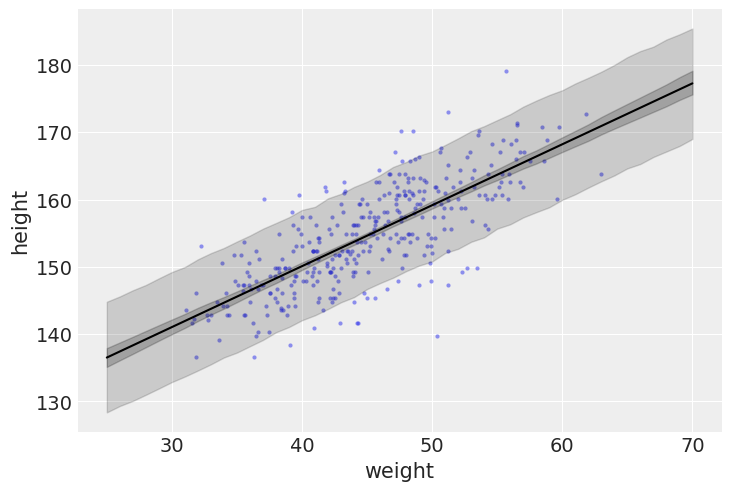

In [75]:
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)
# draw MAP line
plt.plot(weight_seq, mu_mean, "k")
# draw HPDI region for line
plt.fill_between(weight_seq, mu_HPDI[0], mu_HPDI[1], color="k", alpha=0.2)
# draw PI region for simulated heights
plt.fill_between(weight_seq, height_PI[0], height_PI[1], color="k", alpha=0.15)
plt.show()

## 4.5 Curves from lines

In [76]:
# 4.64
Howell = pd.read_csv('../data/Howell1.csv', sep=';')
d = Howell

<Axes: xlabel='weight', ylabel='height'>

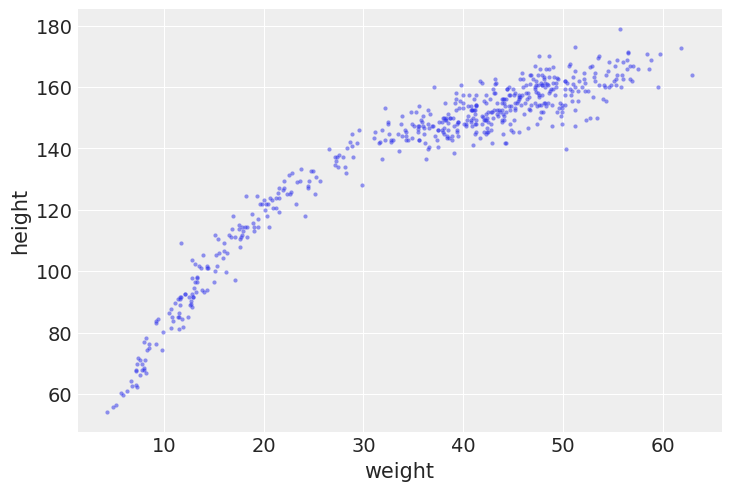

In [77]:
az.plot_pair(d[['weight','height']].to_dict(orient='list'),
            scatter_kwargs={"alpha": 0.5})

Standardizing weight (predictor):

“When predictor variables have very large values in them, there are sometimes numerical glitches. Even well-known statistical software can suffer from these glitches, leading to mistaken estimates. These problems are very common for polynomial regression, because the square or cube of a large number can be truly massive. Standardizing largely resolves this issue”

$$h_i \sim \text{Normal}(\mu_, \sigma)$$ height ~ dnorm(mu,sigma)

$$μ_i = α + β_1x_i + β_2{x_i^2}$$ mu <- a + b1*weight.s + b2*weight.s^2

$$α \sim \text{Normal(178, 20)}$$ a ~ dnorm(178,20)

$$β_1 \sim \text{Log-Normal(0, 1)}$$ b1 ~ dlnorm(0,1)

$$β_2 \sim \text{Normal(0, 1)}$$ b2 ~ dnorm(0,1)

$$σ \sim \text{Uniform(0, 50)}$$ sigma ~ dunif(0,50)

In [78]:
# 4.65
d['weight_s'] = (d.weight - d.weight.mean())/d.weight.std()
d['weight_s2'] = d.weight_s**2

def model(weight_s, weight_s2, height=None):
    a = numpyro.sample('a', dist.Normal(178,20))
    b1 = numpyro.sample('b1', dist.LogNormal(0,1))
    b2 = numpyro.sample('b2', dist.Normal(0,1))
    sigma = numpyro.sample('sigma', dist.Uniform(0,50))
    mu = numpyro.deterministic('mu', a + b1 * weight_s + b2 * weight_s2)
    numpyro.sample('height', dist.Normal(mu,sigma), obs=height)

m4_5 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m4_5,
    optim.Adam(0.3),
    Trace_ELBO(),
    weight_s=d.weight_s.values,
    weight_s2=d.weight_s2.values,
    height=d.height.values,)

svi_result = svi.run(random.PRNGKey(0), 3000)
p4_5 = svi_result.params

100%|█| 3000/3000 [00:00<00:00, 11227.93it/s, init loss: 68267.6406, avg. loss [


In [79]:
# 4.66
samples = m4_5.sample_posterior(random.PRNGKey(1), p4_5, (1000,))
print_summary({k: v for k, v in samples.items() if k != "mu"}, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a    146.05      0.36    146.03    145.47    146.58   1049.96      1.00
        b1     21.75      0.30     21.75     21.25     22.18    886.88      1.00
        b2     -7.79      0.28     -7.79     -8.21     -7.32   1083.62      1.00
     sigma      5.78      0.17      5.78      5.49      6.02    973.21      1.00



Calculate the mean relationship and 89% intervals of the mean and predictions:

In [80]:
# 4.67
# sample standardized weights from -2.2 to 2
weight_seq = jnp.linspace(start=-2.2,stop=2,num=30)
# select weight data 
pred_dat = {"weight_s": weight_seq, "weight_s2": weight_seq**2}
# sample 1000 samples from posterior distribution of model
post = m4_5.sample_posterior(random.PRNGKey(1), p4_5, (1000,))
# predict mean height for each sample drawn from the posterior
predictive = Predictive(m4_5.model, post)
mu = predictive(random.PRNGKey(2), **pred_dat)['mu']
# calculate mean of all mu values from PPD
mu_mean = jnp.mean(mu,0)
# calculate 89% PI of mu values from PPD
mu_PI = jnp.percentile(mu, q=jnp.array([5.5,94.5]),axis=0)
# get simulated heights
sim_height = predictive(random.PRNGKey(3), **pred_dat)["height"]
# calculated 89% PI of simulated heights
height_PI = jnp.percentile(sim_height, q=jnp.array([5.5, 94.5]), axis=0)

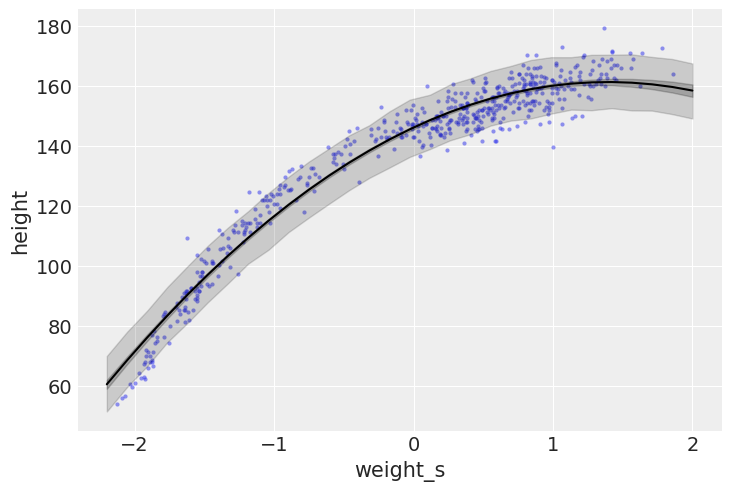

In [81]:
# 4.68
az.plot_pair(
    d[["weight_s", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)
plt.plot(weight_seq, mu_mean, "k")
plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.fill_between(weight_seq, height_PI[0], height_PI[1], color="k", alpha=0.15)
plt.show()

Fit a cubic instead of quadratic model instead:

In [82]:
# 4.69
d["weight_s3"] = d.weight_s**3

def model(weight_s, weight_s2, weight_s3, height=None):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b1 = numpyro.sample("b1", dist.LogNormal(0, 1))
    b2 = numpyro.sample("b2", dist.Normal(0, 1))
    b3 = numpyro.sample("b3", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    # convert this to numpyro.deterministic to fix errors!
    mu = numpyro.deterministic('mu', a + b1 * weight_s + b2 * weight_s2 + b3 * weight_s3)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_6 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m4_6,
    optim.Adam(0.3),
    Trace_ELBO(),
    weight_s=d.weight_s.values,
    weight_s2=d.weight_s2.values,
    weight_s3=d.weight_s3.values,
    height=d.height.values,
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p4_6 = svi_result.params

100%|█| 1000/1000 [00:00<00:00, 4432.84it/s, init loss: 5544.0449, avg. loss [95


In [83]:
weight_seq = jnp.linspace(start=-2.2, stop=2, num=30)
pred_dat = {"weight_s": weight_seq,
            "weight_s2": weight_seq**2,
            "weight_s3": weight_seq**3}
post = m4_6.sample_posterior(random.PRNGKey(1), p4_6, (1000,))
predictive = Predictive(m4_6.model, post)
mu = predictive(random.PRNGKey(2), **pred_dat)['mu']
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5, 94.5]), axis=0)
sim_height = predictive(random.PRNGKey(3), **pred_dat)["height"]
height_PI = jnp.percentile(sim_height, q=jnp.array([5.5, 94.5]), axis=0)

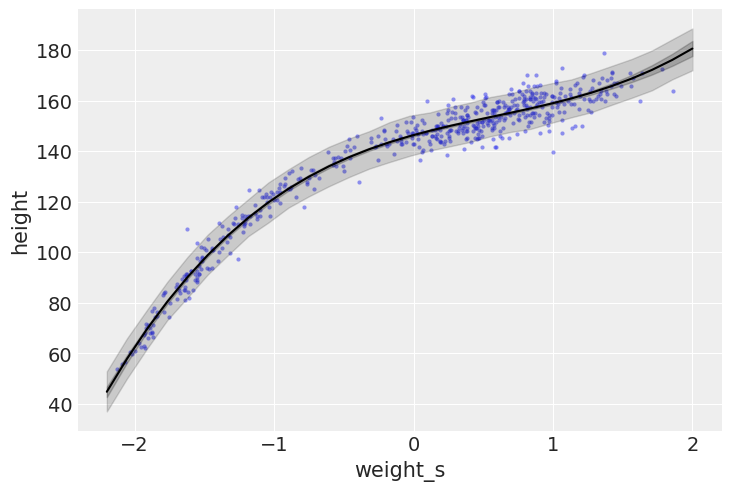

In [84]:
az.plot_pair(
    d[["weight_s", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)
plt.plot(weight_seq, mu_mean, "k")
plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.fill_between(weight_seq, height_PI[0], height_PI[1], color="k", alpha=0.15)
plt.show()

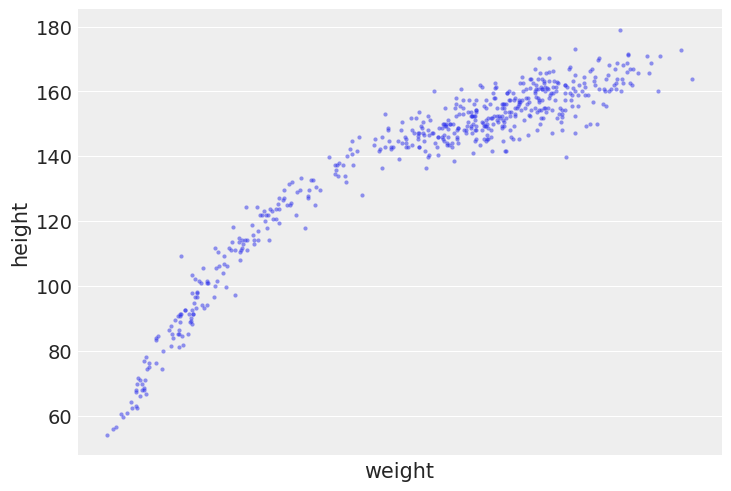

In [85]:
# 4.70
ax = az.plot_pair(
    d[["weight_s", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)
ax.set(xlabel="weight", ylabel="height", xticks=[])
fig = plt.gcf()

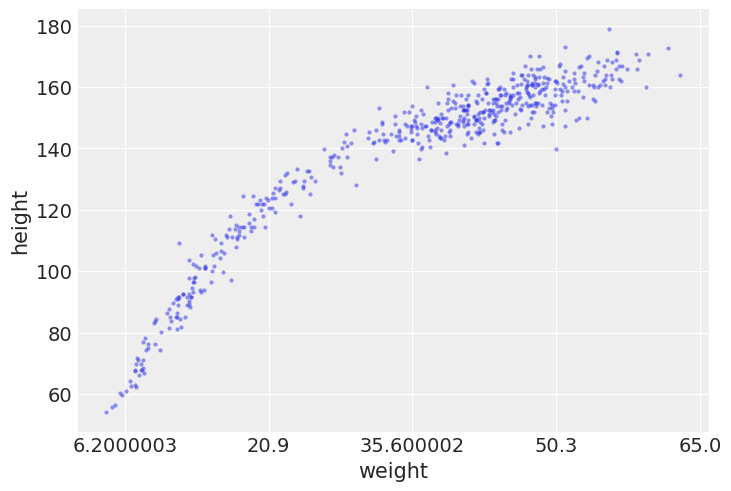

In [86]:
# 4.71
at = jnp.array([-2, -1, 0, 1, 2])
labels = at * d.weight.std() + d.weight.mean()
ax.set_xticks(at)
ax.set_xticklabels([round(label, 1) for label in labels])
fig

### 4.5.2 Splines

In [87]:
# 4.72
cherry_blossoms = pd.read_csv("../data/cherry_blossoms.csv", sep=";")
d = cherry_blossoms

In [88]:
# 4.73
d2 = d[d.doy.notna()]
num_knots = 15
knot_list = jnp.quantile(
    d2.year.values.astype(float),
    q=jnp.linspace(0,1,num=num_knots)
)
knot_list

Array([ 812.    , 1036.0001, 1174.    , 1269.    , 1377.    , 1454.    ,
       1518.    , 1583.    , 1650.0001, 1714.    , 1774.    , 1833.0001,
       1893.0001, 1956.    , 2015.    ], dtype=float32)

In [89]:
# 4.74
# Define basis functions at degree 3 (= 4 functions combine at any given knot)
knots = jnp.pad(knot_list, (3,3), mode='edge')
B = BSpline(knots,
            jnp.identity(num_knots+2),
            k=3)(d2.year.values)

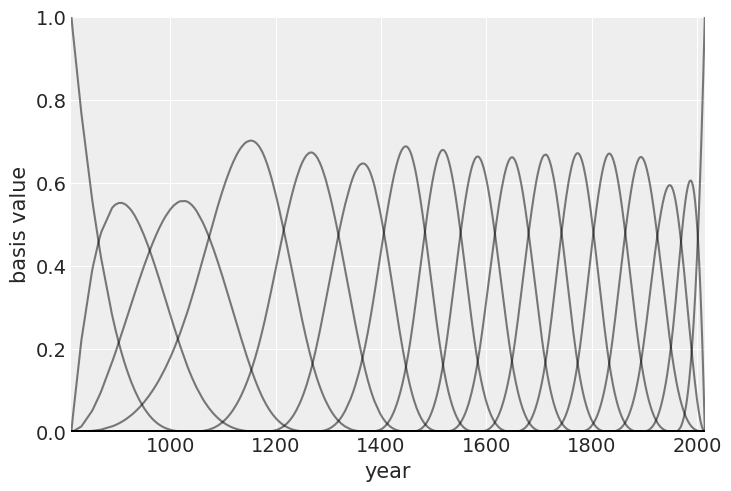

In [90]:
# 4.75
plt.subplot(
    xlim=(d2.year.min(), d2.year.max()),
    ylim=(0,1),
    xlabel='year',
    ylabel='basis value',
)
for i in range(B.shape[1]):
    plt.plot(d2.year, B[:,i], 'k', alpha=0.5)

$$T_i \sim \text{Normal}(μ_i, σ)$$

$$μ_i = α + \sum^{K}_{k=1}w_k B_{k,i}$$

$$α \sim \text{Normal(6, 10)}$$

$$w_j \sim \text{Normal(0, 1)}$$

$$σ \sim \text{Exponential(1)}$$

In [91]:
# 4.76
def model(B, T):
    a = numpyro.sample("a", dist.Normal(100, 10))
    w = numpyro.sample("w", dist.Normal(0, 10).expand(B.shape[1:]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + B @ w)
    numpyro.sample("T", dist.Normal(mu, sigma), obs=T)


start = {"w": jnp.zeros(B.shape[1])}
m4_7 = AutoLaplaceApproximation(model, init_loc_fn=init_to_value(values=start))
svi = SVI(model, m4_7, optim.Adam(1), Trace_ELBO(), B=B, T=d2.doy.values)
svi_result = svi.run(random.PRNGKey(0), 20000)
p4_7 = svi_result.params

100%|█| 20000/20000 [00:00<00:00, 21323.23it/s, init loss: 2476234.7500, avg. lo


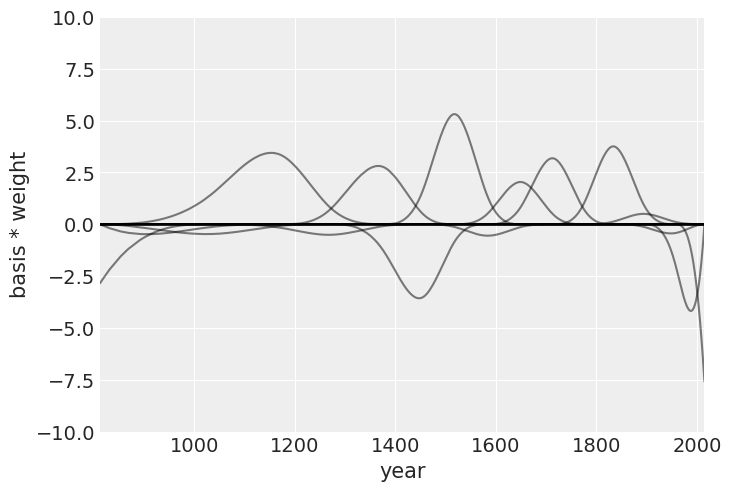

In [92]:
# 4.77
# Plot posterior predictions
post = m4_7.sample_posterior(random.PRNGKey(1), p4_7, (1000,))
w = jnp.mean(post['w'], 0)
plt.subplot(
    xlim=(d2.year.min(), d2.year.max()),
    ylim=(-10, 10),
    xlabel="year",
    ylabel="basis * weight",
)
for i in range(B.shape[1]):
    plt.plot(d2.year, (w[i] * B[:, i]), "k", alpha=0.5)

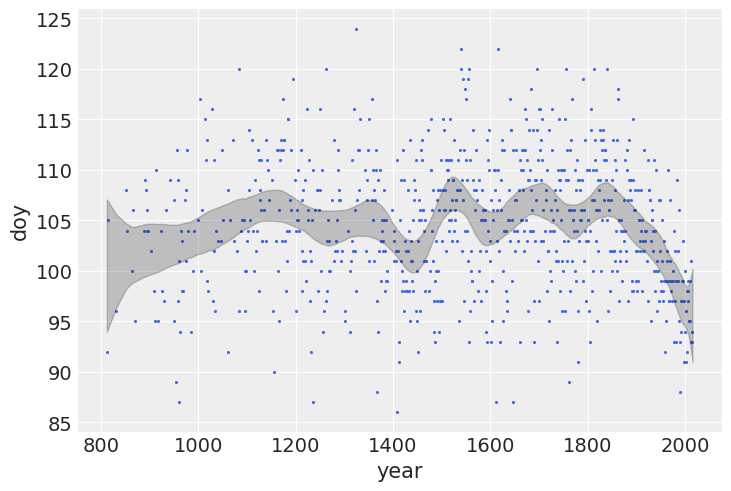

In [93]:
# 4.78
# 97% posterior interval for mu at each year
mu = post["mu"]
mu_PI = jnp.percentile(mu, q=jnp.array([1.5, 98.5]), axis=0)
az.plot_pair(
    d2[["year", "doy"]].astype(float).to_dict(orient="list"),
    scatter_kwargs={"c": "royalblue", "alpha": 1, "s": 20},
)
plt.fill_between(d2.year, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.show()

100%|█| 20000/20000 [00:01<00:00, 19962.97it/s, init loss: 2476347.5000, avg. lo


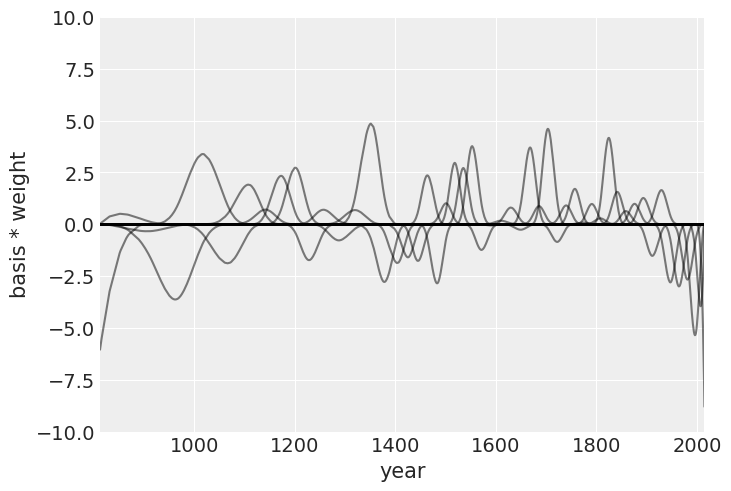

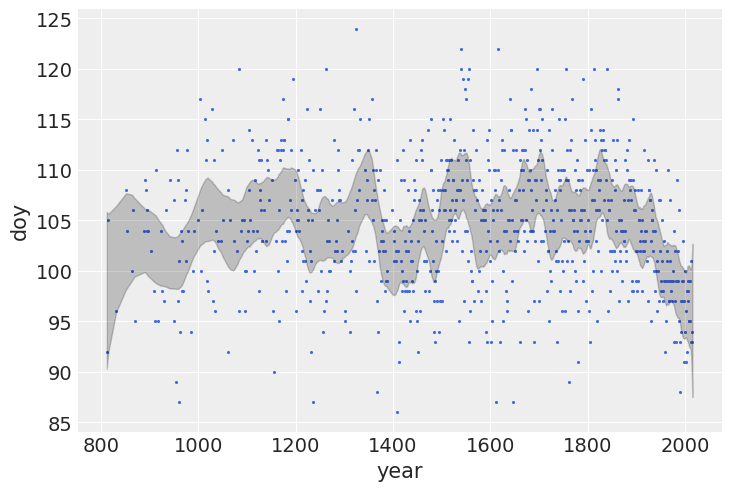

In [94]:
d2 = d[d.doy.notna()]
num_knots = 50
knot_list = jnp.quantile(
    d2.year.values.astype(float),
    q=jnp.linspace(0,1,num=num_knots)
)
knot_list



# 4.74
# Define basis functions at degree 3 (= 4 functions combine at any given knot)
degree = 3
knots = jnp.pad(knot_list, (degree,degree), mode='edge')
B = BSpline(knots,
            jnp.identity(num_knots+2),
            k=degree)(d2.year.values)




# 4.76
def model(B, T):
    a = numpyro.sample("a", dist.Normal(100, 10))
    w = numpyro.sample("w", dist.Normal(0, 10).expand(B.shape[1:]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + B @ w)
    numpyro.sample("T", dist.Normal(mu, sigma), obs=T)


start = {"w": jnp.zeros(B.shape[1])}
m4_7 = AutoLaplaceApproximation(model, init_loc_fn=init_to_value(values=start))
svi = SVI(model, m4_7, optim.Adam(1), Trace_ELBO(), B=B, T=d2.doy.values)
svi_result = svi.run(random.PRNGKey(0), 20000)
p4_7 = svi_result.params



# 4.77
# Plot posterior predictions
post = m4_7.sample_posterior(random.PRNGKey(1), p4_7, (1000,))
w = jnp.mean(post['w'], 0)
plt.subplot(
    xlim=(d2.year.min(), d2.year.max()),
    ylim=(-10, 10),
    xlabel="year",
    ylabel="basis * weight",
)
for i in range(B.shape[1]):
    plt.plot(d2.year, (w[i] * B[:, i]), "k", alpha=0.5)




# 4.78
# 97% posterior interval for mu at each year
mu = post["mu"]
mu_PI = jnp.percentile(mu, q=jnp.array([1.5, 98.5]), axis=0)
az.plot_pair(
    d2[["year", "doy"]].astype(float).to_dict(orient="list"),
    scatter_kwargs={"c": "royalblue", "alpha": 1, "s": 20},
)
plt.fill_between(d2.year, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.show()

## Exercises

Below are only the exercises with code implementations, manual questions were kept in a (paper) notebook.

### 4M1

For the model definition below, simulate observed y values from the prior (not the posterior):

yi ∼ Normal(μ, σ)

μ ∼ Normal(0, 10)

σ ∼ Exponential(1)

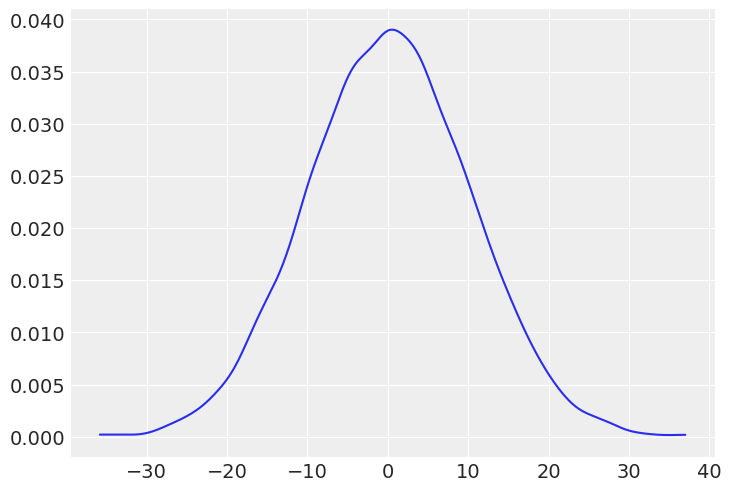

In [95]:
sample_mu = dist.Normal(0,10).sample(random.PRNGKey(0), (int(1e4),))
sample_sigma = dist.Exponential(1).sample(random.PRNGKey(1), (int(1e4),))
prior_h = dist.Normal(sample_mu, sample_sigma).sample(random.PRNGKey(2))
az.plot_kde(prior_h)
plt.show()

### 4M2

Translate the model just above into a ~quap~ NumPyro formula

In [96]:
def model(c):
    mu = numpyro.sample('mu', dist.Normal(0,10))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    numpyro.sample('y', dist.Normal(mu, sigma), obs=c)

### 4H1

The weights listed below were recorded in the !Kung census, but heights were not recorded for these individuals. Provide predicted heights and 89% intervals for each of these individuals. That is, fill in the table below, using model-based predictions. 

- 46.95
- 43.72
- 64.78
- 32.59
- 54.63

In [97]:
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1
d2 = d[d["age"] >= 18]

# define the average weight, x-bar
xbar = d2.weight.mean()


# fit model
def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * (weight - xbar))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_3 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m4_3,
    optim.Adam(1),
    Trace_ELBO(),
    weight=d2.weight.values,
    height=d2.height.values,
)
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_3 = svi_result.params

100%|█| 2000/2000 [00:00<00:00, 9162.07it/s, init loss: 40631.5430, avg. loss [1


In [98]:
# 4.58
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
mu_link = lambda weight: post['a'] + post['b'] * (weight - xbar)

In [101]:
weight_missing = jnp.array([46.95, 43.72, 64.78, 32.59, 54.63])

In [102]:
# Use Predictive() to compute mu for each sample from posterior and for each weight in weight_seq
mu = Predictive(m4_3.model, post, return_sites=["mu"])(
    random.PRNGKey(2), weight_missing, None
)["mu"]
mu_mean = jnp.mean(mu,0)
mu_HPDI = hpdi(mu, prob=0.89, axis=0)

In [103]:
mu_mean

Array([156.39424, 153.46875, 172.5431 , 143.38814, 163.35008], dtype=float32)

In [104]:
mu_HPDI

array([[155.96324, 152.996  , 171.18846, 142.40715, 162.60478],
       [156.87433, 153.87465, 173.99763, 144.29553, 164.17406]],
      dtype=float32)

### 4H2

Select out all the rows in the Howell1 data with ages below 18 years of age. If you do it right, you should end up with a new data frame with 192 rows in it.

In [105]:
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1
d2 = d[d["age"] < 18]
d2.shape

(192, 4)

(a) Fit a linear regression to these data, using quap. Present and interpret the estimates. For every 10 units of increase in weight, how much taller does the model predict a child gets?

<Axes: xlabel='age', ylabel='height'>

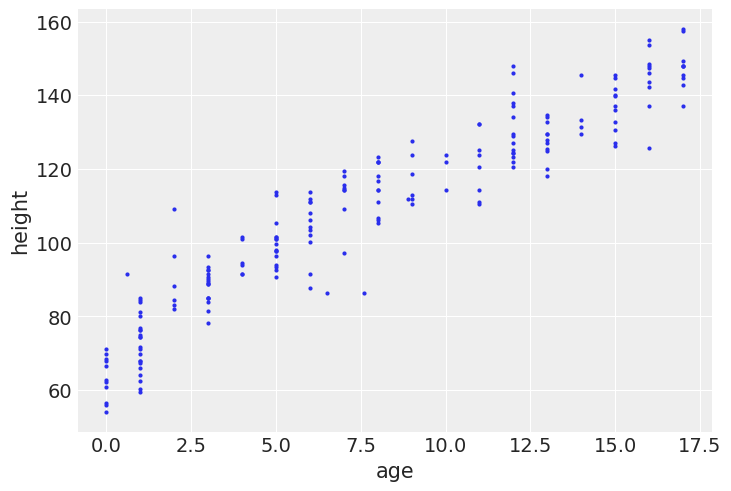

In [106]:
az.plot_pair(d2[['age', 'height']].to_dict(orient='list'))

array([[<Axes: >]], dtype=object)

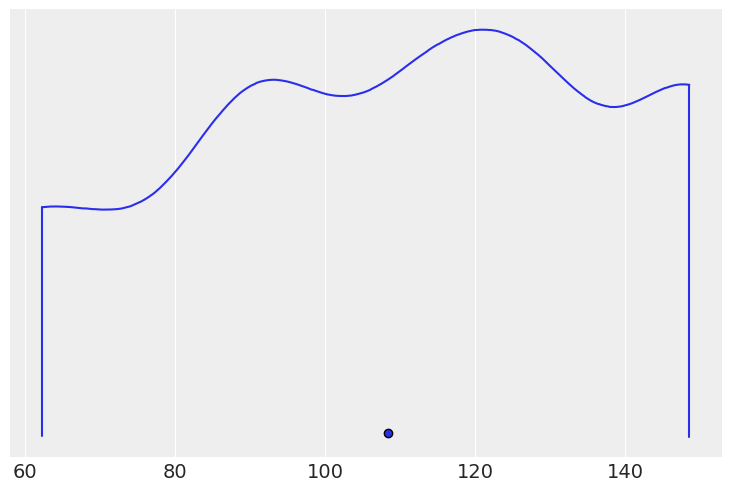

In [107]:
az.plot_density({"": d2.height})

In [108]:
print(d2.height.mean())
print(d2.height.std())

108.31885312499999
25.74513904868482


In [109]:
?AutoNormal

Object `AutoNormal` not found.


In [110]:
# define the average weight, x-bar
xbar = d2.weight.mean()

# fit model
def model(weight, height):
    a = numpyro.sample("a", dist.Normal(90, 30))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 100))
    mu = numpyro.deterministic("mu", a + b * (weight - xbar))
 
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

from numpyro.infer.autoguide import AutoNormal

m4_8 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m4_8,
    optim.Adam(1),
    Trace_ELBO(),
    weight=d2.weight.values,
    height=d2.height.values,
)
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_8 = svi_result.params

100%|█| 2000/2000 [00:00<00:00, 9301.21it/s, init loss: 3482.2649, avg. loss [19


In [111]:
# Marginal posterior distributions of the parameters
samples = m4_8.sample_posterior(random.PRNGKey(1), p4_8, (1000,))
samples.pop('mu')
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a    108.35      0.62    108.37    107.33    109.28    931.50      1.00
         b      2.72      0.07      2.72      2.62      2.84   1096.01      1.00
     sigma      8.47      0.44      8.47      7.82      9.22    949.04      1.00



<Axes: xlabel='weight', ylabel='height'>

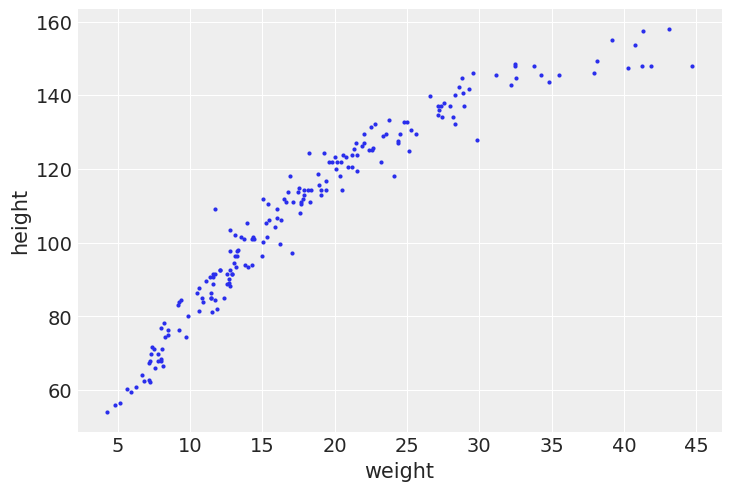

In [112]:
az.plot_pair(d2[['weight', 'height']].to_dict(orient='list'))

"10 units of increase in weight, how much taller does the model predict a child gets?"

We interpret this as 10 * $\beta$ being an increase of 27 cm for the associated weight increase.

(b) Plot the raw data, with height on the vertical axis and weight on the horizontal axis. Superimpose the MAP regression line and 89% interval for the mean. Also superimpose the 89% interval for predicted heights.

In [113]:
weight_seq = jnp.arange(start=1, stop=50, step=1)
mu = Predictive(m4_8.model, post, return_sites=["mu"])(
    random.PRNGKey(2), weight_seq, None
)["mu"]
# summarize the distribution of mu
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5, 94.5]), axis=0)

In [114]:
# Simulate heights
sim_height = Predictive(m4_8.model, post, return_sites=["height"])(
    random.PRNGKey(2), weight_seq, None
)["height"]
height_PI = jnp.percentile(sim_height, q=jnp.array([5.5, 94.5]), axis=0)

<function matplotlib.pyplot.show(close=None, block=None)>

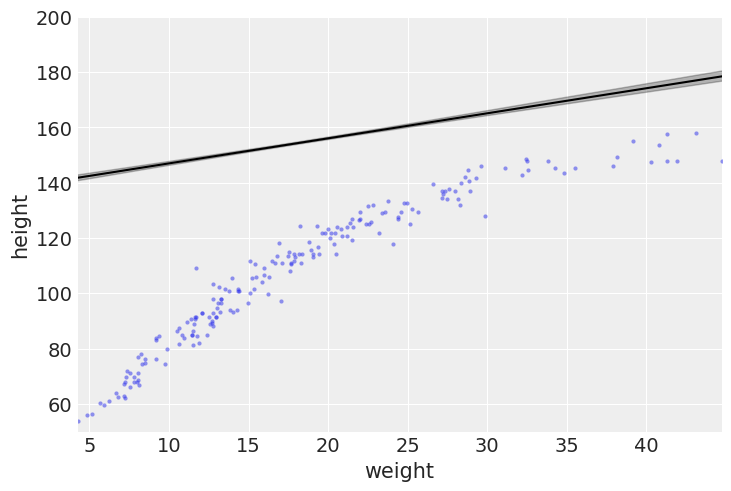

In [115]:
ax = az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"),
    scatter_kwargs={"alpha": 0.5}
)
ax.set(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(50, 200)
)

# plot the MAP line, aka the mean mu for each weight
plt.plot(weight_seq, mu_mean, "k")
# plot a shaded region for 89% PI
plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.25)
plt.show

### 4H4

Plot the prior predictive distribution for the polynomial regression model in the chapter. You can modify the code that plots the linear regression prior predictive distribution.

Can you modify the prior distributions of α, β1, and β2 so that the prior predictions stay within the biologically reasonable outcome space? That is to say: Do not try to fit the data by hand. But do try to keep the curves consistent with what you know about height and weight, before seeing these exact data.

In [116]:
# 4.65
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1
d2 = d[d["age"] >= 18]

d2['weight_s'] = (d2.weight - d2.weight.mean())/d2.weight.std()
d2['weight_s2'] = d2.weight_s**2

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [117]:
# 4.41
with numpyro.handlers.seed(rng_seed=2971):
    N = 1000
    a = numpyro.sample('a', dist.Normal(178,20).expand([N]))
    b1 = numpyro.sample('b1', dist.LogNormal(0,1).expand([N]))
    b2 = numpyro.sample('b2', dist.Normal(0,1).expand([N]))

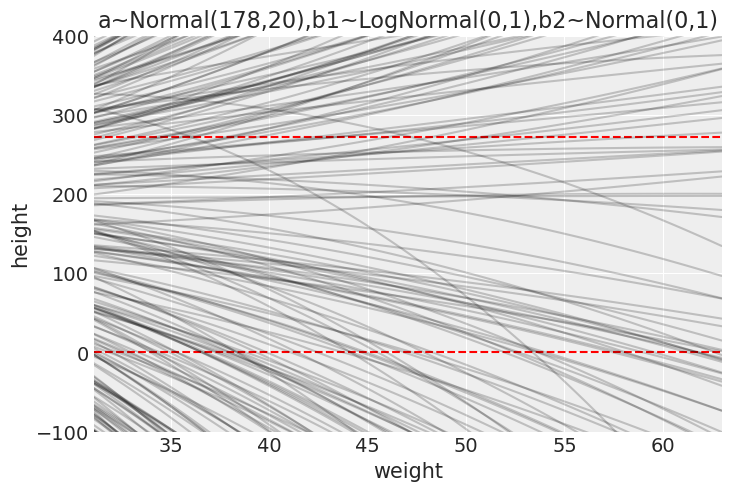

In [118]:
x1 = jnp.linspace(d2.weight_s.min(), d2.weight_s.max(), 101)
x2 = jnp.linspace(d2.weight_s2.min(), d2.weight_s2.max(), 101)

plt.subplot(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(-100, 400),
    xlabel="weight",
    ylabel="height",
)
plt.axhline(y=0, c="r", ls="--")
plt.axhline(y=272, c="r", ls="--",)
xbar = d2.weight.mean()
plt.title('a~Normal(178,20),b1~LogNormal(0,1),b2~Normal(0,1)')
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b1[i] * (x) + b2[i] * (x**2), "k", alpha=0.2)
plt.show()

Obviously, these values do not make sense as they range far _above_ and _below_ biological limits (red lines).

What is the influence of the Normal distribution fitted on b2? What is the space of weight_s_2 and how does a ND coefficient for the polynomial affect the fit?

array([[<Axes: title={'center': 'weight_s2'}>]], dtype=object)

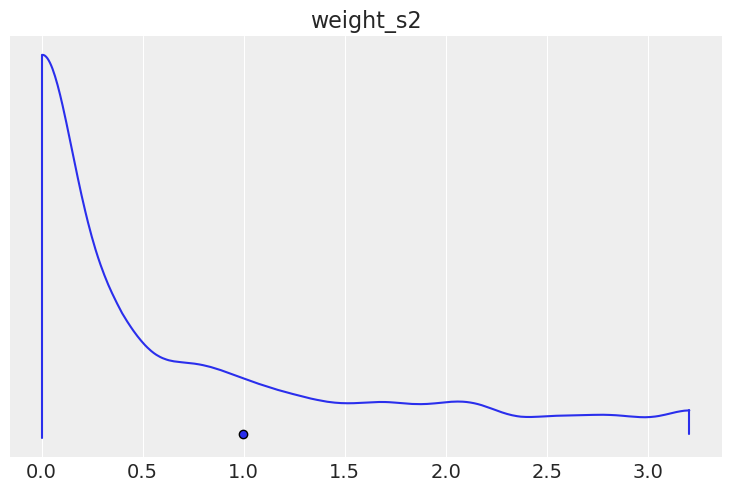

In [119]:
az.plot_density({"weight_s2": d2.weight_s2})

In [120]:
print_summary(dict(zip(d2.columns, d2.T.values)), 0.89, False)


                 mean       std    median      5.5%     94.5%     n_eff     r_hat
        age     41.14     15.97     39.00     18.00     64.00    272.29      1.00
     height    154.60      7.74    154.31    142.24    166.37    403.51      1.00
       male      0.47      0.50      0.00      0.00      1.00    696.80      1.00
     weight     44.99      6.46     44.79     35.47     56.02    362.29      1.00
   weight_s      0.00      1.00     -0.03     -1.48      1.71    362.29      1.00
  weight_s2      1.00      1.22      0.48      0.00      2.64    361.91      1.01



In [121]:
print(d2.weight.min())

print(d2.weight.max())

31.071052
62.992589


In [122]:
-1.96*62.99

-123.4604

I suspect that squaring `d2.weight` and multiplying with a possible negative coefficient `b2` strongly affects results outside human limits. Would it be reasonable to limit to to a LogNormal distribution as well, without tweaking the exact distribution parameters. Alternatively, could we impose a Uniform distribution to set limits?

In [123]:
# 4.41
with numpyro.handlers.seed(rng_seed=2971):
    N = 1000
    a = numpyro.sample('a', dist.Normal(178,20).expand([N]))
    b1 = numpyro.sample('b1', dist.LogNormal(0,1).expand([N]))
    b2 = numpyro.sample('b2', dist.LogNormal(0,1).expand([N]))

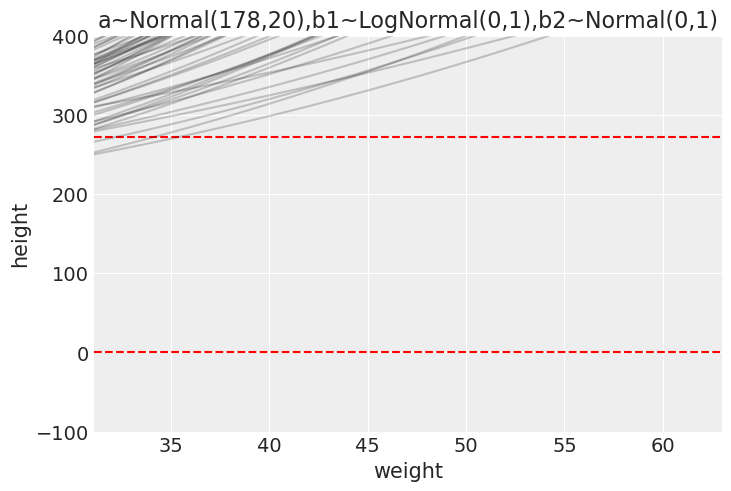

In [124]:
x1 = jnp.linspace(d2.weight_s.min(), d2.weight_s.max(), 101)
x2 = jnp.linspace(d2.weight_s2.min(), d2.weight_s2.max(), 101)

plt.subplot(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(-100, 400),
    xlabel="weight",
    ylabel="height",
)
plt.axhline(y=0, c="r", ls="--")
plt.axhline(y=272, c="r", ls="--",)
xbar = d2.weight.mean()
plt.title('a~Normal(178,20),b1~LogNormal(0,1),b2~Normal(0,1)')
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b1[i] * (x) + b2[i] * (x**2), "k", alpha=0.2)
plt.show()

In [125]:
# 4.41
with numpyro.handlers.seed(rng_seed=2971):
    N = 1000
    a = numpyro.sample('a', dist.Normal(-190,5).expand([N]))
    b1 = numpyro.sample('b1', dist.Normal(13,0.2).expand([N]))
    b2 = numpyro.sample('b2', dist.Uniform(-0.13,-0.1).expand([N]))

So the "avoid trial-and-error" message was perhaps not present in the previous edition, but these prior values below from https://sr2-solutions.wjakethompson.com/linear-models-causal-inference are incredible.

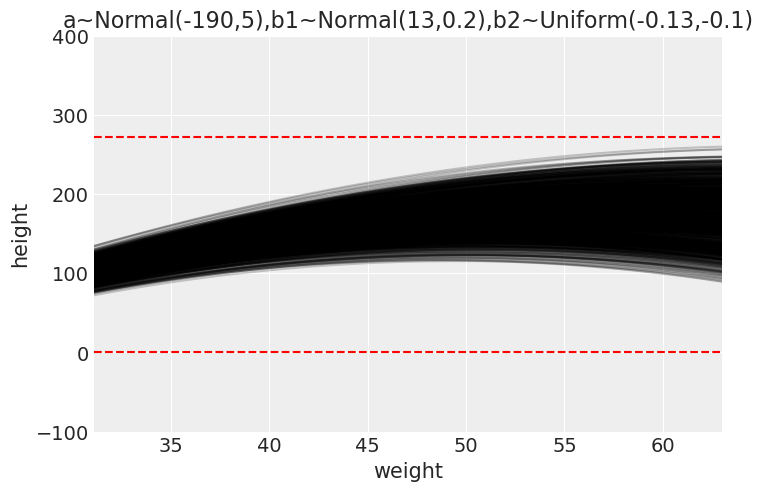

In [126]:
x1 = jnp.linspace(d2.weight_s.min(), d2.weight_s.max(), 101)
x2 = jnp.linspace(d2.weight_s2.min(), d2.weight_s2.max(), 101)

plt.subplot(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(-100, 400),
    xlabel="weight",
    ylabel="height",
)
plt.axhline(y=0, c="r", ls="--")
plt.axhline(y=272, c="r", ls="--",)
xbar = d2.weight.mean()
plt.title('a~Normal(-190,5),b1~Normal(13,0.2),b2~Uniform(-0.13,-0.1)')
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b1[i] * (x) + b2[i] * (x**2), "k", alpha=0.2)
plt.show()

Quick flashback before continuing to next chapter:

"Unlike β1, we don’t want a positive constraint. In the problems at the end of the chapter, you’ll use prior predictive simulation to understand why. These polynomial parameters are in general very difficult to set realistic priors for, which is another reason to avoid polynomial models" (p115)